In [1]:
# others
# colab drive mount 
import os 
import pandas as pd
import numpy as np
import argparse
import datetime
from copy import deepcopy # Add Deepcopy for args
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import IPython
import IPython.display

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
 
 
print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6) 

# read file
df = pd.read_hdf('./data/merged_data.h5')

1.6.0+cpu
Populating the interactive namespace from numpy and matplotlib


In [34]:
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    return array_3d

# raw_array = df2d_to_array3d(df)
# print(f'raw array shape is {raw_array.shape}')

In [35]:
# def time_split(input_array, split_size = 6):

#     # origin size define
#     index_size = input_array.shape[0]
#     origin_time_size = input_array.shape[1]
#     variable_size = input_array.shape[2]

#     # new array size define
#     new_time_size = int(origin_time_size/split_size) # 1380 / 6
#     new_array = np.zeros((index_size, new_time_size, variable_size))

#     for idx in range(index_size):
#         for time_idx in range(new_time_size):
            

#             first_time_idx = time_idx * split_size
#             last_time_idx = ((time_idx+1) * split_size) -1

#             new_array[idx, time_idx, 0] = input_array[idx, first_time_idx, 0] #coin_num
#             new_array[idx, time_idx, 1] = input_array[idx, first_time_idx, 1] #open
            
#             new_array[idx, time_idx, 2] = np.max(input_array[idx, first_time_idx:last_time_idx, 2]) #high
#             new_array[idx, time_idx, 3] = np.min(input_array[idx, first_time_idx:last_time_idx, 3]) #low

#             new_array[idx, time_idx, 4] = input_array[idx, last_time_idx, 4] #close

#             new_array[idx, time_idx, 5] = np.sum(input_array[idx, first_time_idx:last_time_idx, 5]) #etc
#             new_array[idx, time_idx, 6] = np.sum(input_array[idx, first_time_idx:last_time_idx, 6]) #etc
#             new_array[idx, time_idx, 7] = np.sum(input_array[idx, first_time_idx:last_time_idx, 7]) #etc
#             new_array[idx, time_idx, 8] = np.sum(input_array[idx, first_time_idx:last_time_idx, 8]) #etc
#             new_array[idx, time_idx, 9] = np.sum(input_array[idx, first_time_idx:last_time_idx, 9]) #etc

#     return new_array

# split_array = time_split(raw_array, split_size = 6)
# print(f'split array shape is {split_array.shape}')

In [45]:
# def train_val_test_spliter(arr):
    
    
#     n = len(arr)
#     num_features = arr.shape[2] - 1
    
#     train_arr = arr[0:int(n*0.7), :, 1:]
#     val_arr = arr[int(n*0.7):int(n*0.9), :, 1:]
#     test_arr = arr[int(n*0.9):, : , 1:]

    
#     n2 = len(train_arr) + len(val_arr) + len(test_arr)
    
#     print(
#     f'''
#     ======================================================
#     Origin length is {n}, then total split length is {n2}
#     ======================================================
#     train length is {train_arr.shape},
#     val length is {val_arr.shape},
#     test length is {test_arr.shape},
#     num_features is ({num_features})
#     '''
#     )
    
#     return train_arr, val_arr, test_arr, num_features

# train_arr, val_arr, test_arr, num_features = train_val_test_spliter(split_array)


def train_val_test_spliter(train_raw_arr, test_raw_arr):
    
    n = len(train_raw_arr) + len(test_raw_arr)

    train_arr = train_raw_arr[0:int(n*0.8), :, 1:]
    val_arr = train_raw_arr[int(n*0.8):, :, 1:]
    test_arr = test_raw_arr[:, :, 1:]

    num_features = train_arr.shape[2]
    n2 = len(train_arr) + len(val_arr) + len(test_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {n2}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    test length is {test_arr.shape},
    num_features is ({num_features})
    '''
    )
    
    return train_arr, val_arr, test_arr, num_features

In [46]:
# test 해야할 sample index 663, 98, 308, 808, 148
test_sample_list = [663, 98, 308, 808, 148]

test_df = df[df.sample_id.isin(test_sample_list)]
train_df =  df[~df.sample_id.isin(test_sample_list)]

train_raw_arr = df2d_to_array3d(train_df)
test_raw_arr = df2d_to_array3d(test_df)

In [47]:
df2d_to_array3d(df).shape

(1208, 1500, 10)

In [48]:
# raw_array = df2d_to_array3d(df)
# print(f'raw array shape is {raw_array.shape}')
train_arr, val_arr, test_arr, num_features = train_val_test_spliter(train_raw_arr, test_raw_arr)


    Origin length is 1208, then total split length is 1208
    train length is (966, 1500, 9),
    val length is (237, 1500, 9),
    test length is (5, 1500, 9),
    num_features is (9)
    


In [10]:
train_mean = train_arr.mean(axis=(0, 1))
train_std = train_arr.std(axis=(0, 1))

ntrain_arr = (train_arr - train_mean) / train_std
nval_arr = (val_arr - train_mean) / train_std
ntest_arr = (test_arr - train_mean) / train_std

# dataset partitioning

partition = {'train': ntrain_arr, 'val':nval_arr, 'test':ntest_arr}

In [13]:
df = df.drop(columns = ['sample_id', 'time', 'coin_index'])
column_indices = {name : i for i, name in enumerate(df.columns)}

In [36]:
column_indices

{'open': 0,
 'high': 1,
 'low': 2,
 'close': 3,
 'volume': 4,
 'quote_av': 5,
 'trades': 6,
 'tb_base_av': 7,
 'tb_quote_av': 8}

In [51]:
class WindowGenerator():
    ''' Dataset Generate'''
    def __init__(self, input_width, label_width, stride, data_arr, column_indices = column_indices,
                 shfit = None, label_columns=None):
    
        # Store the raw data
        self.data_arr = data_arr
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = column_indices
                
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = 1
        if shfit is not None:
            self.shift = shfit
        self.stride = stride
        
        self.label_start = self.input_width + self.shift
        self.total_window_size = self.label_start + self.label_width
        
        # input, label indices
        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        self.X_arr, self.y_arr = self.split_windows()
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size -1}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): open'
        ])

    def split_windows(self):

        X, y = list(), list()
        sample_length = int(self.data_arr.shape[0])
        split_length = int((self.data_arr.shape[1] - self.total_window_size)/self.stride) + 1
        
        for temp_id in range(sample_length):
            for i in range(split_length):
                
                X.append(self.data_arr[temp_id, (i*self.stride) : (i*self.stride)+self.input_width])
                y.append(self.data_arr[temp_id, (i*self.stride)+self.label_start : (i*self.stride)+self.total_window_size])

        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X_arr)

    def __getitem__(self, idx):
        
        X = self.X_arr[idx, :, :]
        y = self.y_arr[idx, :, :]

        return X, y

In [38]:
# ====== initialization
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device is",args.device)

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)


# ====== Model Capacity options ===== #
args.input_dim = 4
args.hidden_dim = 50
args.output_dim = 1
args.n_layers = 1
args.batch_size = 256
args.dropout = 0.2
args.use_bn = True

# ====== Dataset Generating options ====== #
args.input_width = 120
args.label_width = 120
args.stride = 10
args.shfit = 0

# ====== Model training options ===== #
args.num_epoch = 10
args.learning_rate = 0.00001
args.L2_rate = 0


device is cpu


In [52]:
trainset = WindowGenerator(input_width=args.input_width, label_width=args.label_width, stride=args.stride, data_arr = ntrain_arr)
valset = WindowGenerator(input_width=args.input_width, label_width=args.label_width, stride=args.stride, data_arr = nval_arr)
testset = WindowGenerator(input_width=args.input_width, label_width=args.label_width, stride=args.stride, data_arr = ntest_arr)
partition = {'train': trainset, 'val':valset, 'test':testset}

In [53]:
trainset

Total window size: 240
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 

In [42]:
for i, (X,y) in enumerate(trainset):
    print(X.shape, y[.shape)

    break

(120, 4) (120, 4)


In [55]:
trainloader = DataLoader(partition['train'], batch_size = args.batch_size, shuffle = True, drop_last = True)
for i, (X,y) in enumerate(trainloader):
    print(f'Inputs shape (batch, time, features): {X.shape}')
    print(f'Labels shape (batch, time, features): {y[:, :, 0].shape}')
    break

Inputs shape (batch, time, features): torch.Size([256, 120, 4])
Labels shape (batch, time, features): torch.Size([256, 120])


In [56]:
class RNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, use_bn):
        super(RNN, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.dropout = dropout
        self.use_bn = use_bn 
        self.rnn = nn.GRU(self.input_dim, self.hidden_dim, self.num_layers)

        self.regressor = self.make_regressor()
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, X):
        rnn_out, self.hidden = self.rnn(X)
        y_pred = self.regressor(rnn_out[-1].view(X.shape[1], -1))
        return y_pred

In [24]:
def train(model, partition, optimizer, loss_fn, args):
    ''' model training '''
   
    # data load
    trainloader = DataLoader(partition['train'],
                             batch_size = args.batch_size,
                             shuffle = True, drop_last = True)
    
    # model's mode setting
    model.train()
    model.zero_grad()
    
    train_loss = 0.0
    
    for i, (X, y) in enumerate(trainloader):
    
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 0].float().to(args.device)
        
        # print(X.shape, y_true.shape)
        
        # zero the gradient
        optimizer.zero_grad()

        model.hidden = model.init_hidden(X.shape[1])

        y_pred = model(X)
        # print(y_pred.shape)
        
        loss = loss_fn(y_true.view(-1), y_pred.view(-1))
        loss.backward()
        optimizer.step()
        
        # get the batch loss
        train_loss += loss.item()
        
    train_loss = train_loss / len(trainloader)
    # train_loss = train_loss*10E5
    return model, train_loss

In [25]:
def validate(model, partition, loss_fn, args):
    ''' model validate '''
    
    # data load
    valloader = DataLoader(partition['val'], 
                           batch_size = args.batch_size, 
                           shuffle = False, drop_last = True)
    
    # model's mode setting
    model.eval()
    val_loss = 0.0
    
    # evaluate
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 0].float().to(args.device)
            
            model.hidden = model.init_hidden(X.shape[1])
            # en-decoder outputs tensor 
            y_pred = model(X)
            # compute the loss 
            loss = loss_fn(y_true.view(-1), y_pred.view(-1))

            # get the batch loss
            val_loss += loss.item()
            
    val_loss = val_loss / len(valloader)
    # val_loss = val_loss * 10E5
    return val_loss

In [31]:
def experiment(partition, args):
    
    model = RNN(args.input_dim, args.hidden_dim, args.label_width, args.n_layers, args.dropout, args.use_bn)
    model.to(args.device)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.L2_rate)
    
    # epoch-wise loss
    train_losses = []
    val_losses = []
    
    print(f'settings are {args}')
    for epoch in range(args.num_epoch):
        
        start_time = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        end_time = time.time()
        
        # add epoch loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch {},Loss(train/val) {:.3f}/{:.3f}. Took {:.2f} sec'.format(epoch+1, train_loss*10E3, val_loss*10E3, end_time-start_time))
    
    # ======= Add Result to Dictionary ======= #
    result = {}    
    result['train_losses'] = train_losses #epoch 수에 의존
    result['val_losses'] = val_losses 

     
    return vars(args), result, model

In [32]:
setting, result, model = experiment(partition, deepcopy(args))

settings are Namespace(L2_rate=0, batch_size=128, device='cpu', dropout=0.2, hidden_dim=50, input_dim=4, input_width=120, label_width=120, learning_rate=1e-05, n_layers=1, num_epoch=200, output_dim=1, shfit=0, stride=10, use_bn=True)
Epoch 1,Loss(train/val) 8351.755/8568.582. Took 112.16 sec
Epoch 2,Loss(train/val) 6512.866/6265.961. Took 109.11 sec


KeyboardInterrupt: 

In [ ]:
# plt.plot(result['train_losses'], label = "train loss")
# plt.plot(result['val_losses'], label = "val loss")
# plt.legend()
# plt.show()

torch.Size([230, 1, 9])
torch.Size([1, 20])
(20,) (20,)


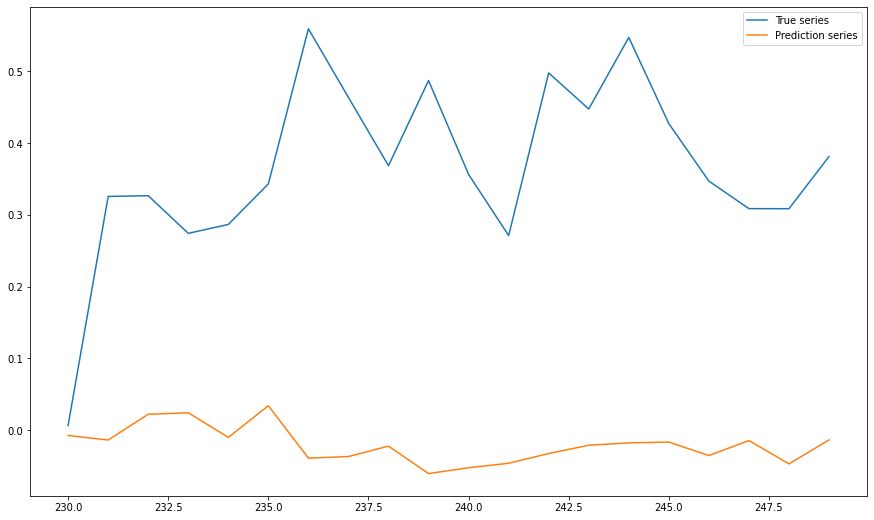

MAE is 0.38681334257125854
(20,) (20,)


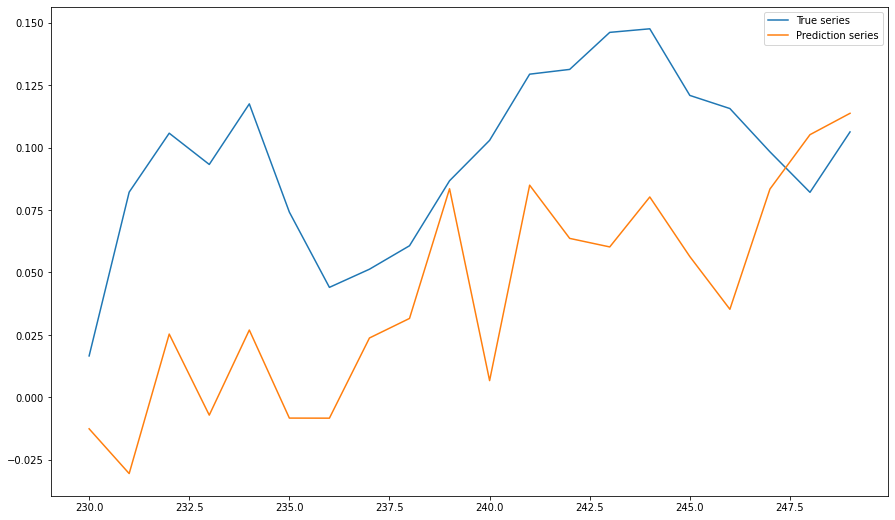

MAE is 0.05800987407565117
(20,) (20,)


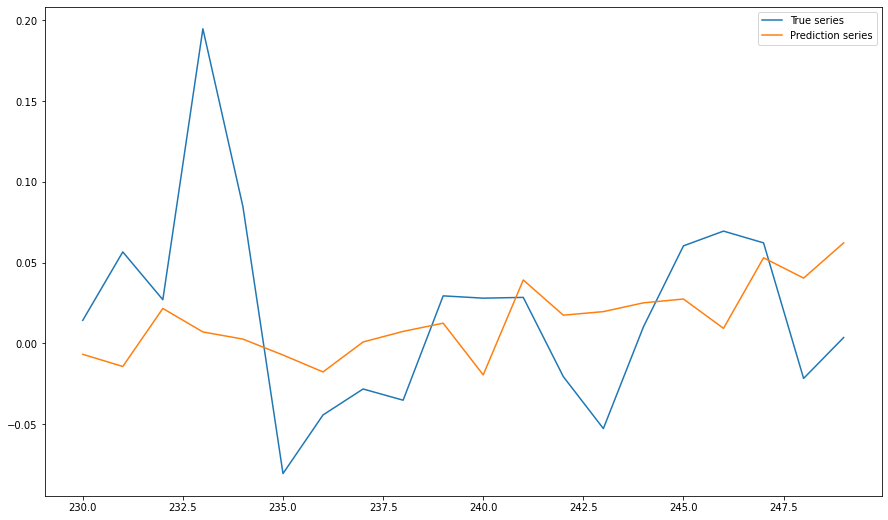

MAE is 0.04807569831609726
(20,) (20,)


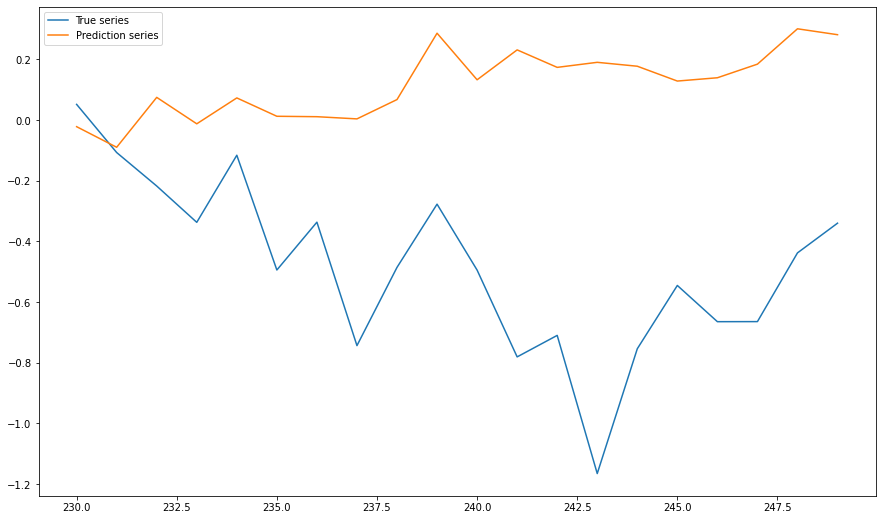

MAE is 0.605768084526062
(20,) (20,)


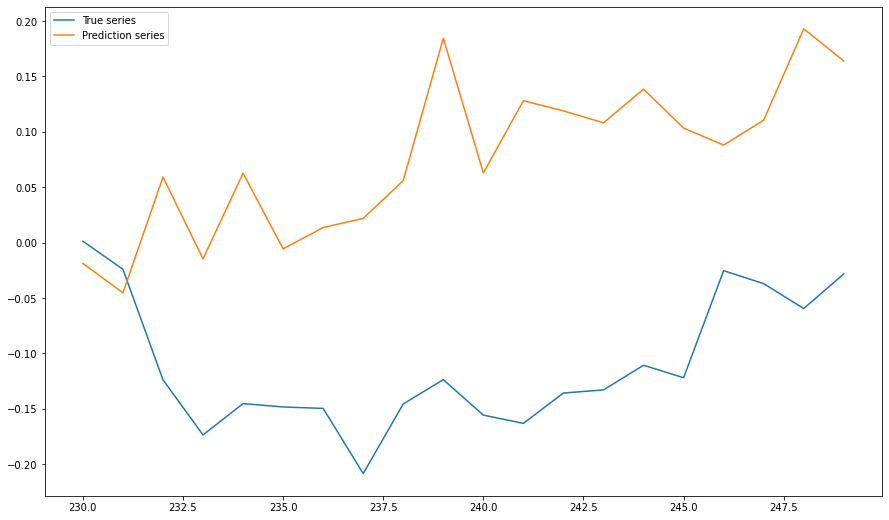

MAE is 0.19112470746040344
(20,) (20,)


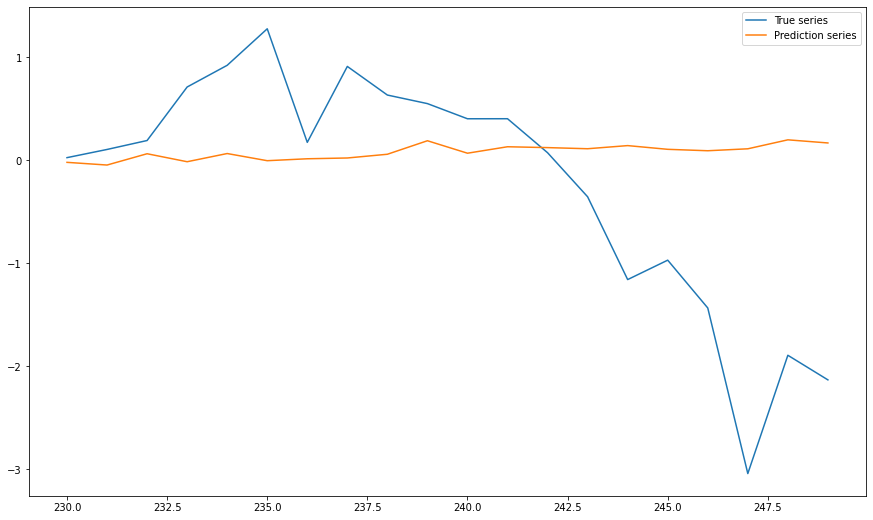

MAE is 0.8866840600967407
(20,) (20,)


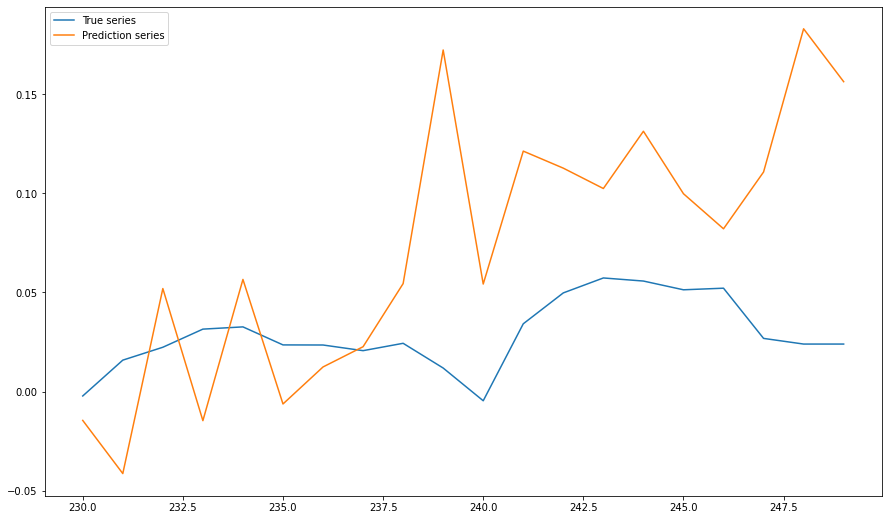

MAE is 0.0592460036277771
(20,) (20,)


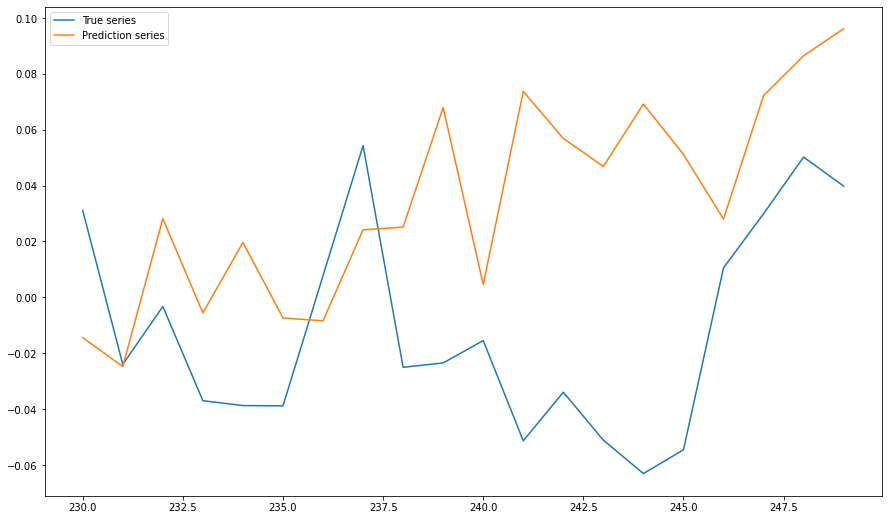

MAE is 0.055561162531375885
(20,) (20,)


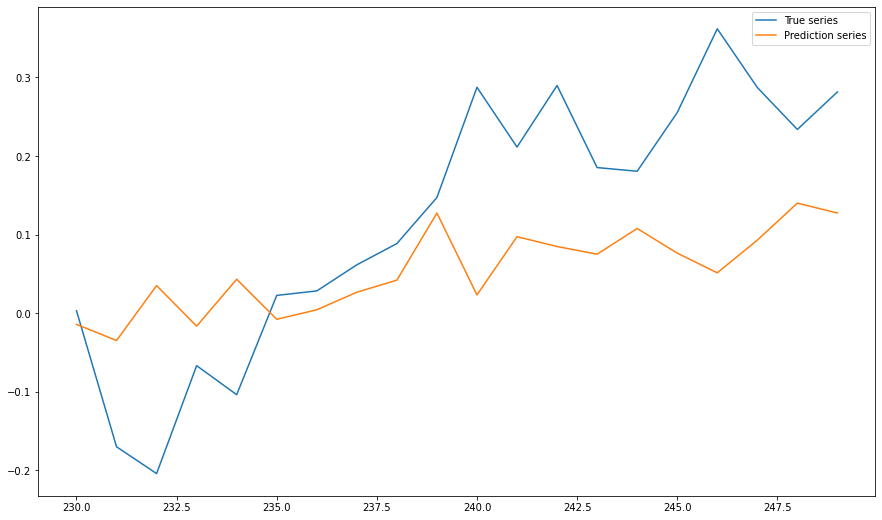

MAE is 0.12212934345006943
(20,) (20,)


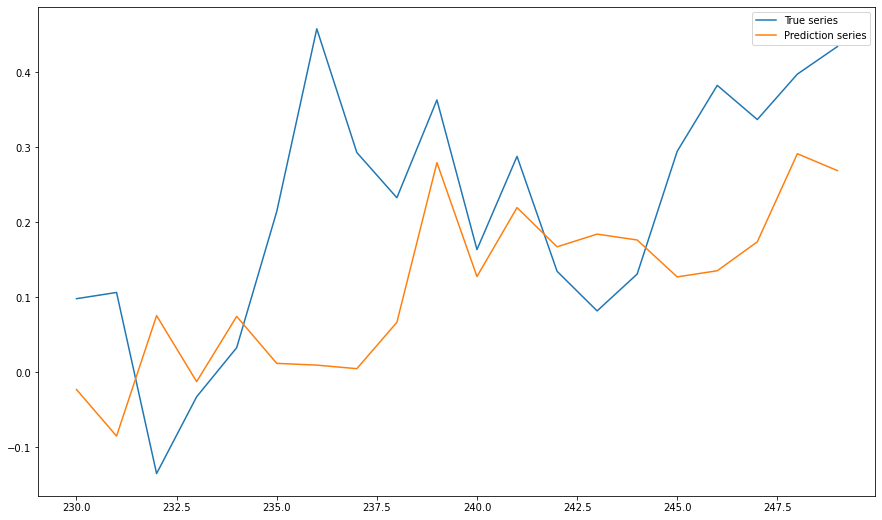

MAE is 0.14532914757728577
(20,) (20,)


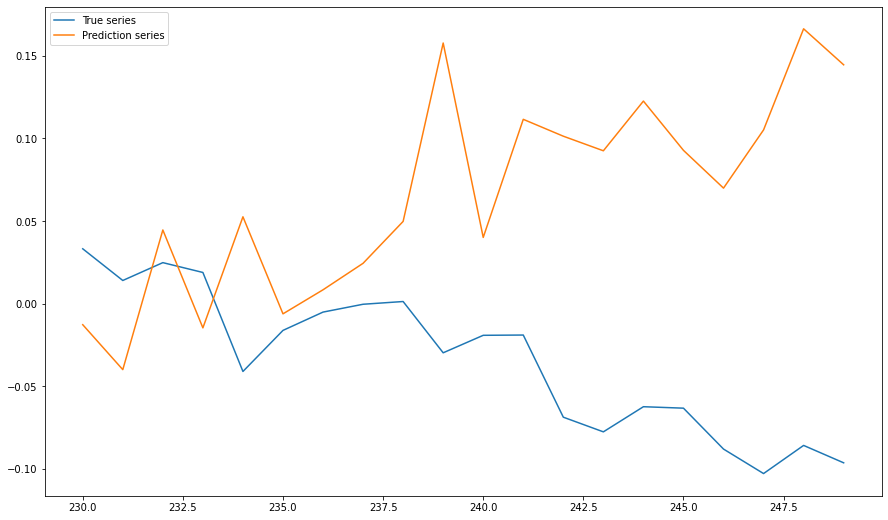

MAE is 0.11306457221508026
(20,) (20,)


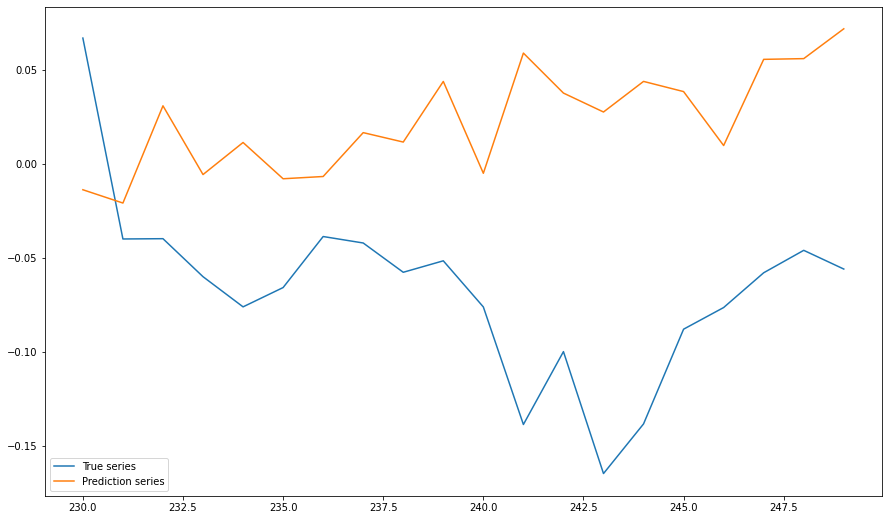

MAE is 0.0981023758649826
(20,) (20,)


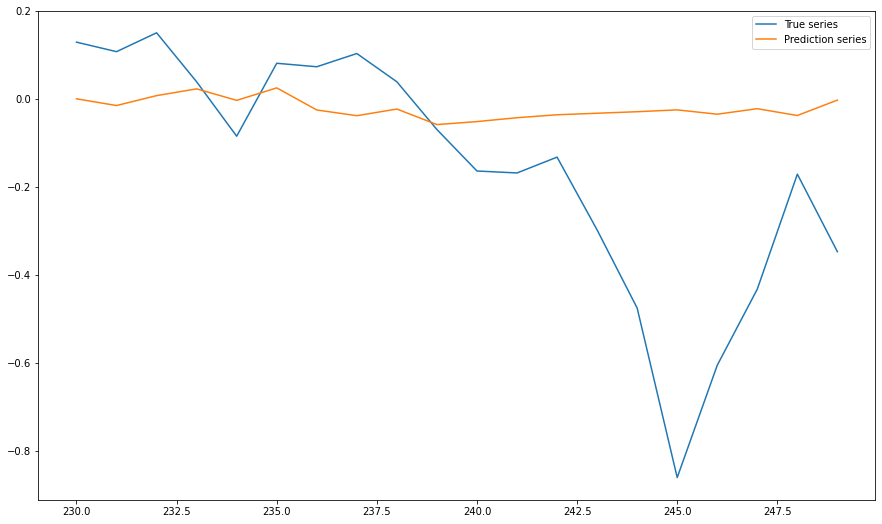

MAE is 0.21010926365852356
(20,) (20,)


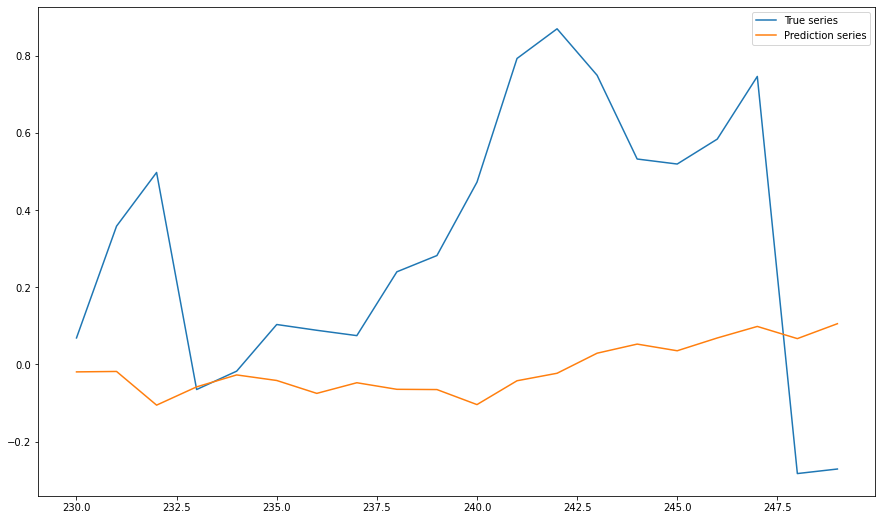

MAE is 0.4021354615688324
(20,) (20,)


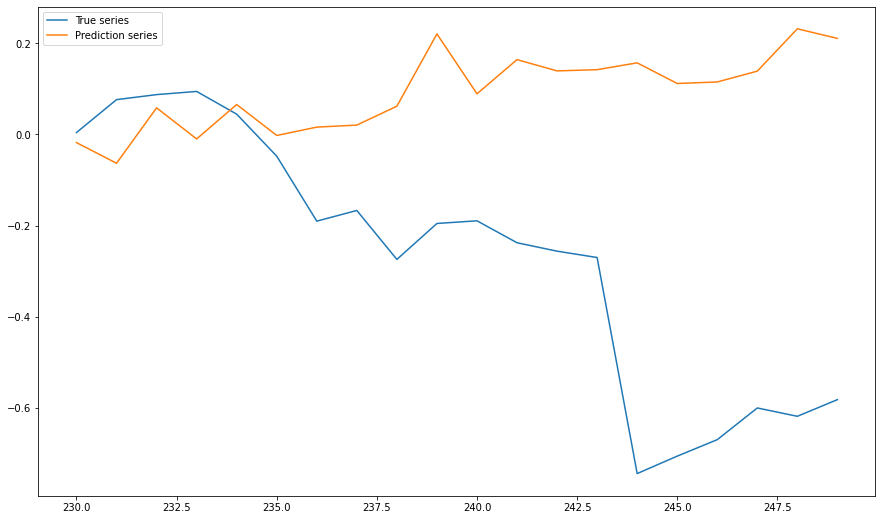

MAE is 0.39437222480773926
(20,) (20,)


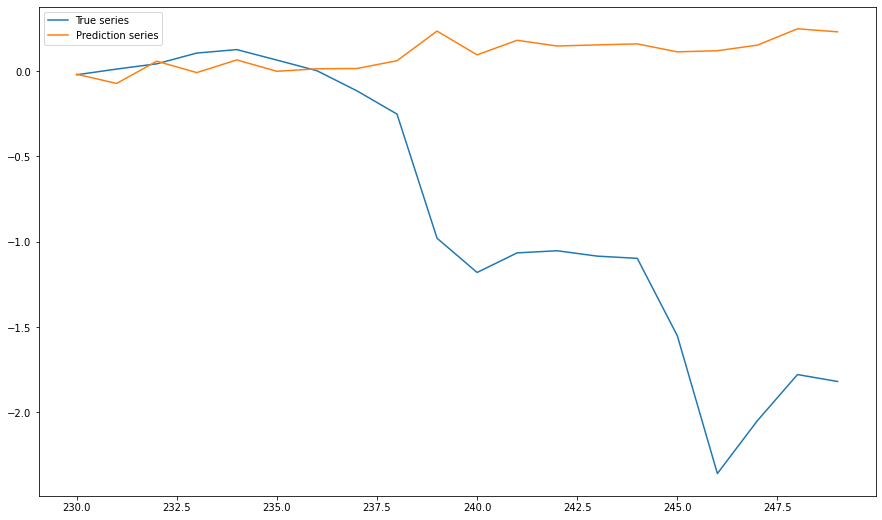

MAE is 0.933650016784668
(20,) (20,)


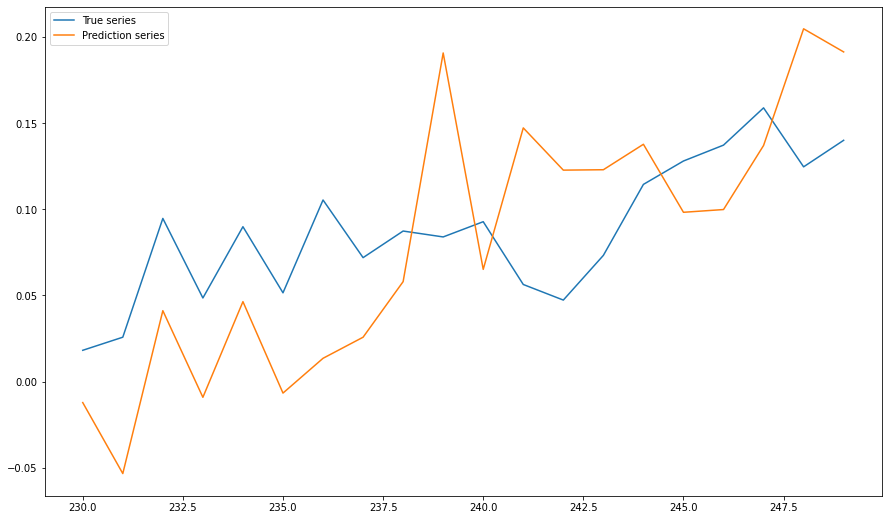

MAE is 0.054167669266462326
(20,) (20,)


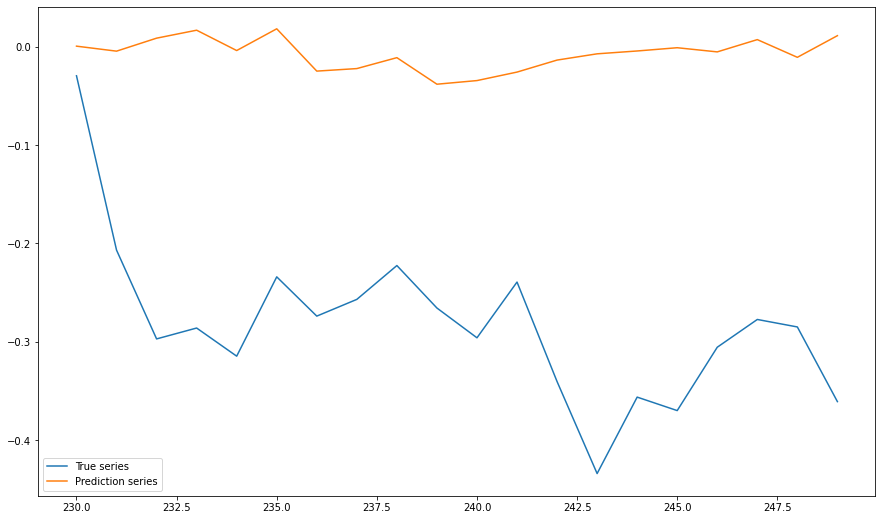

MAE is 0.2755102217197418
(20,) (20,)


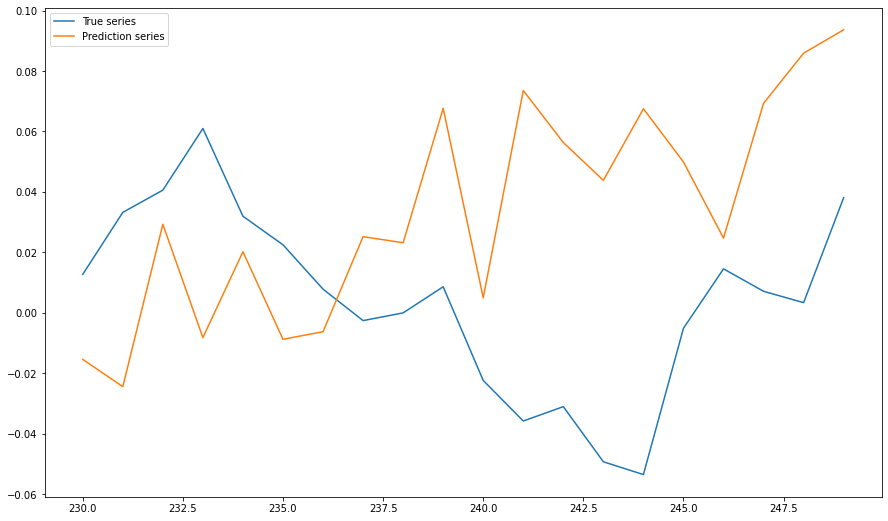

MAE is 0.05187790468335152
(20,) (20,)


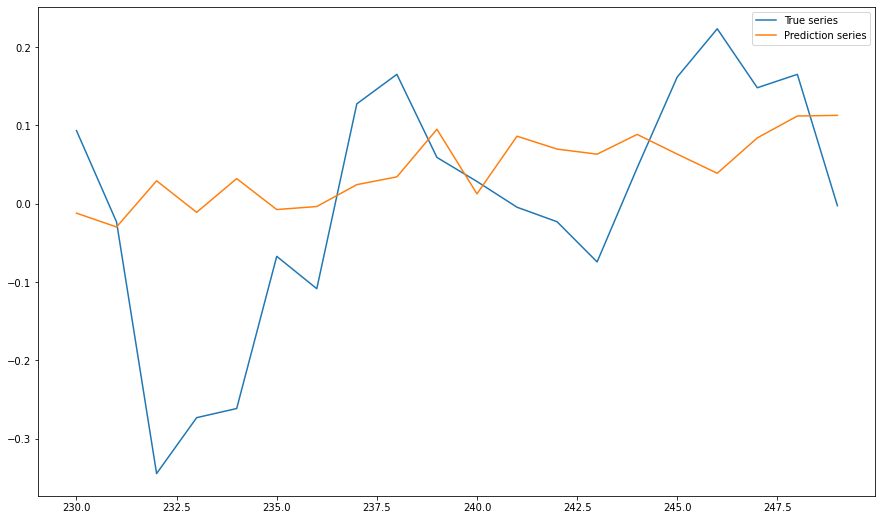

MAE is 0.11849023401737213
(20,) (20,)


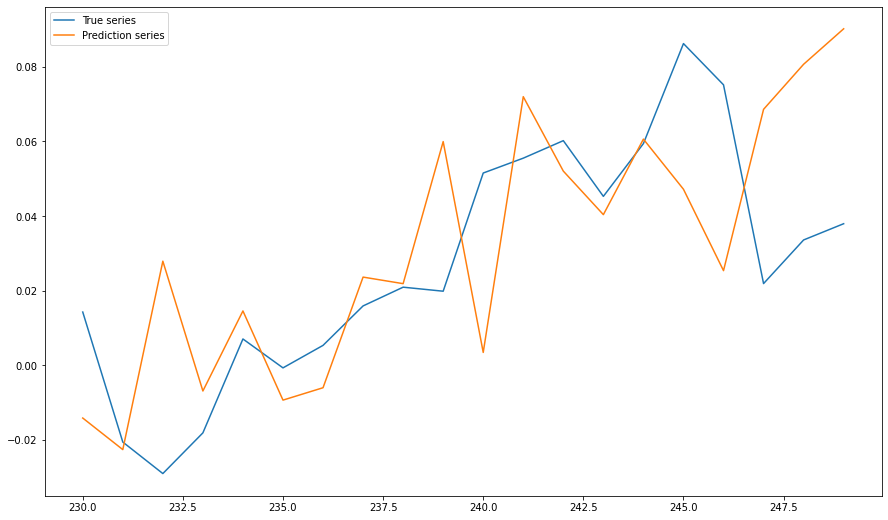

MAE is 0.024427032098174095
(20,) (20,)


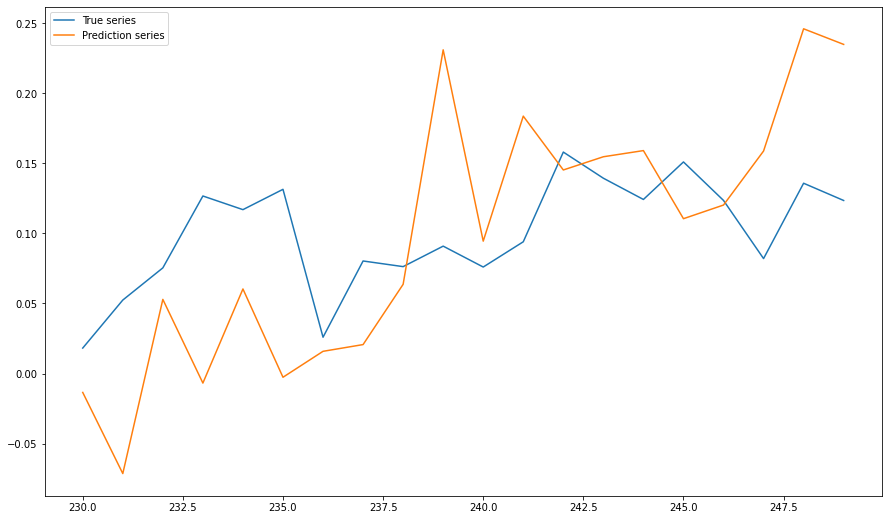

MAE is 0.06190565228462219
(20,) (20,)


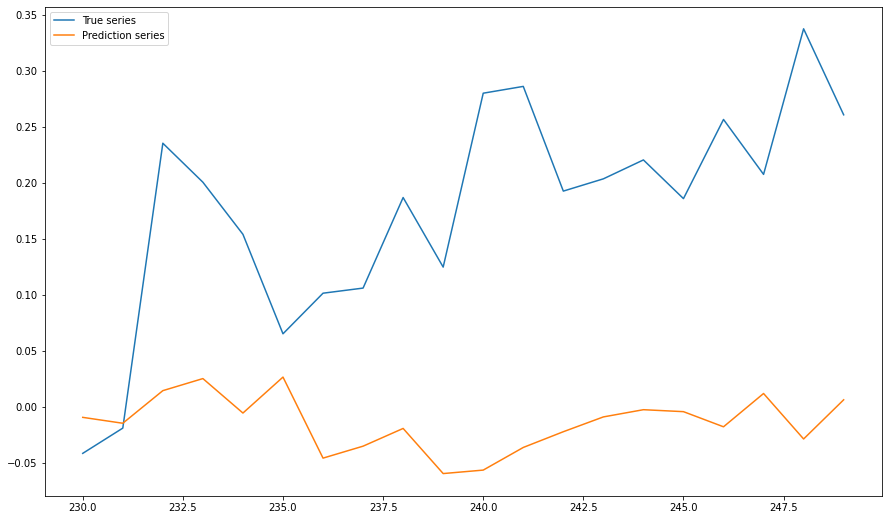

MAE is 0.19491375982761383
(20,) (20,)


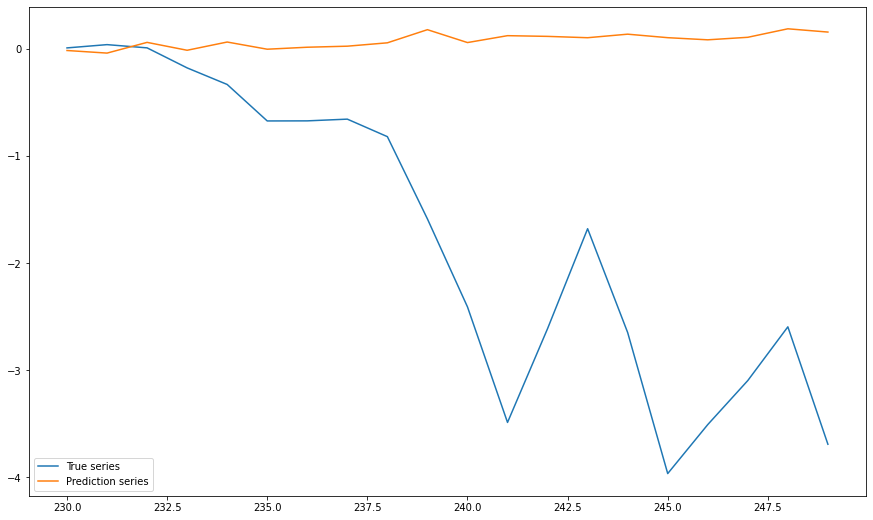

MAE is 1.8124996423721313
(20,) (20,)


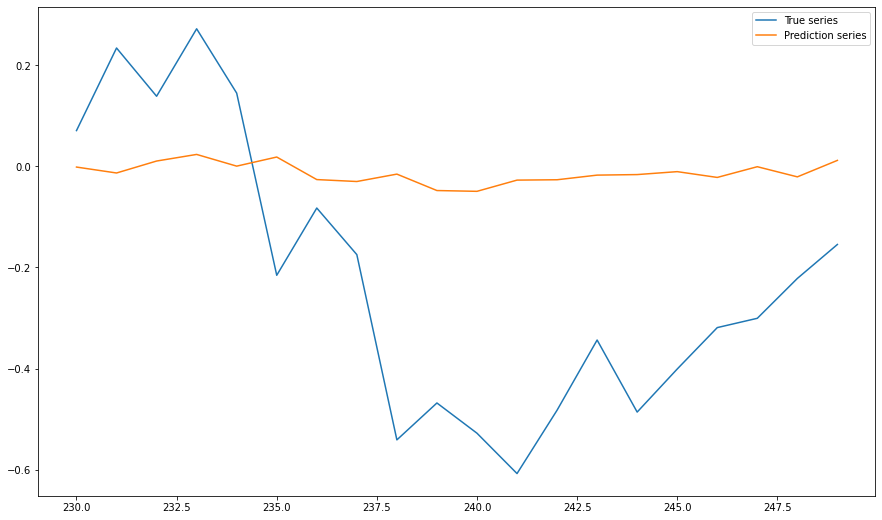

MAE is 0.294141560792923
(20,) (20,)


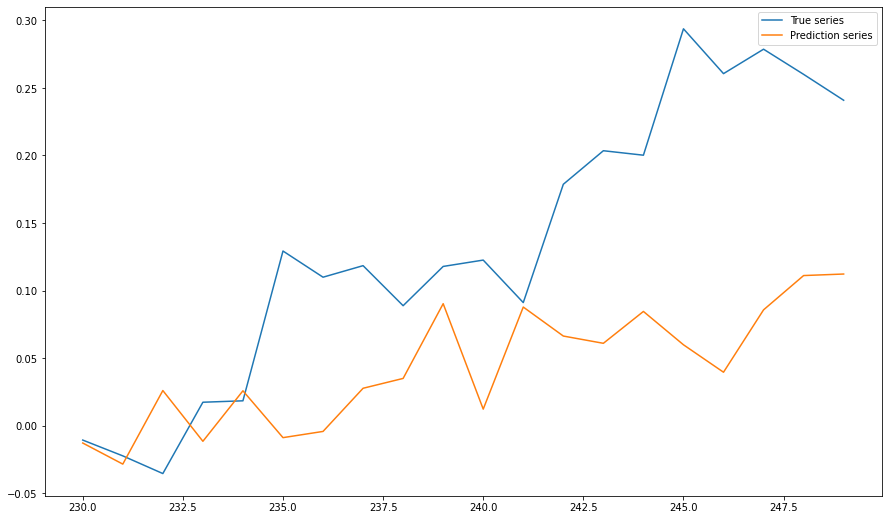

MAE is 0.09696456044912338
(20,) (20,)


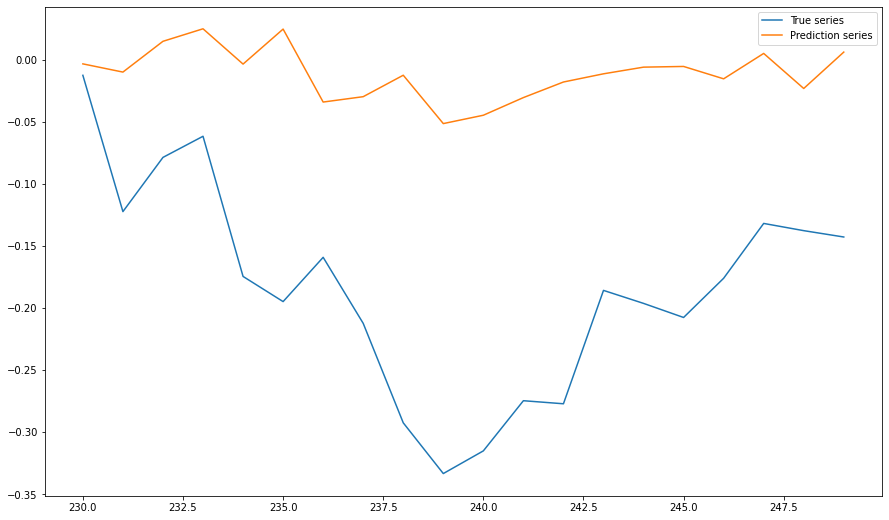

MAE is 0.17328104376792908
(20,) (20,)


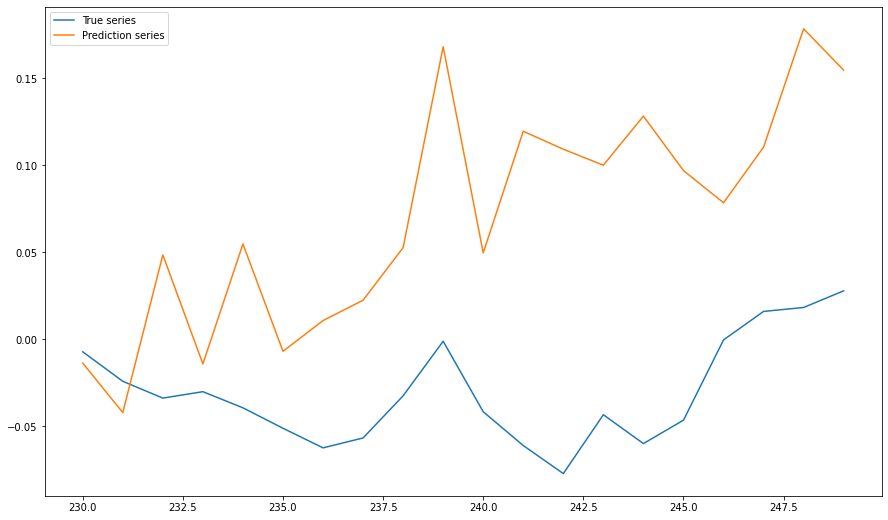

MAE is 0.10300572216510773
(20,) (20,)


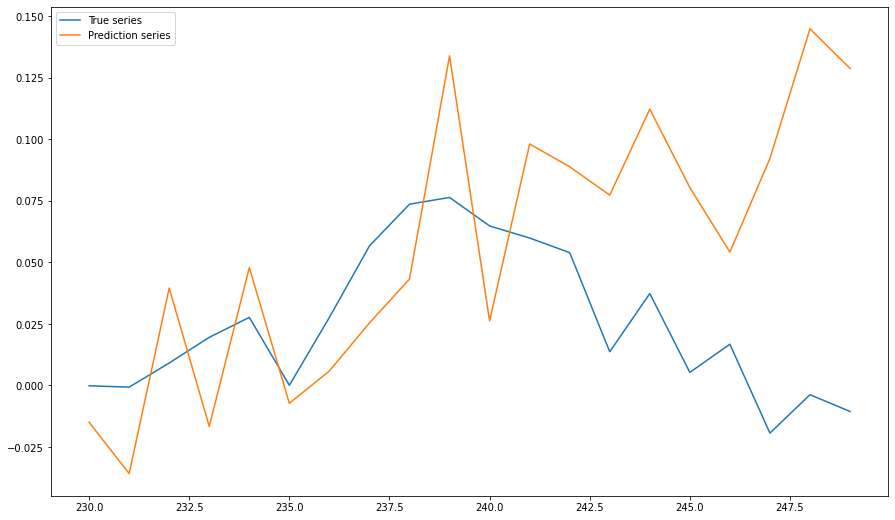

MAE is 0.052350956946611404
(20,) (20,)


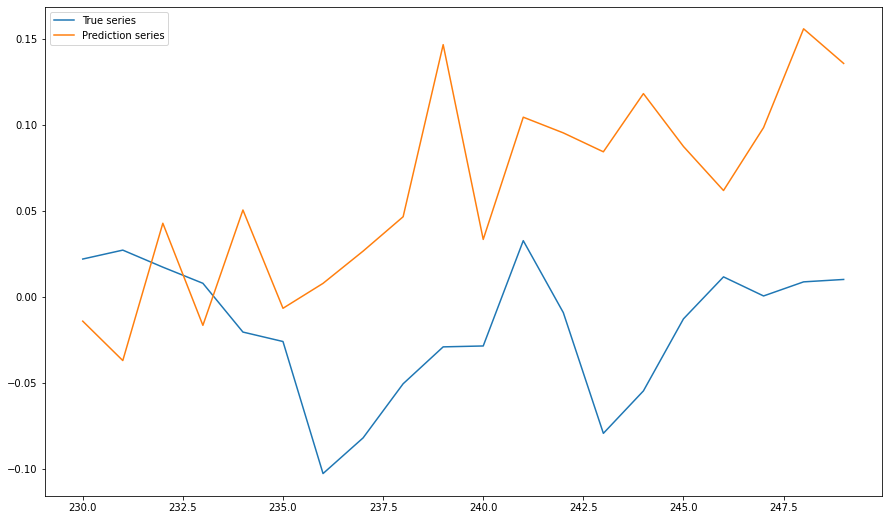

MAE is 0.09143827855587006
(20,) (20,)


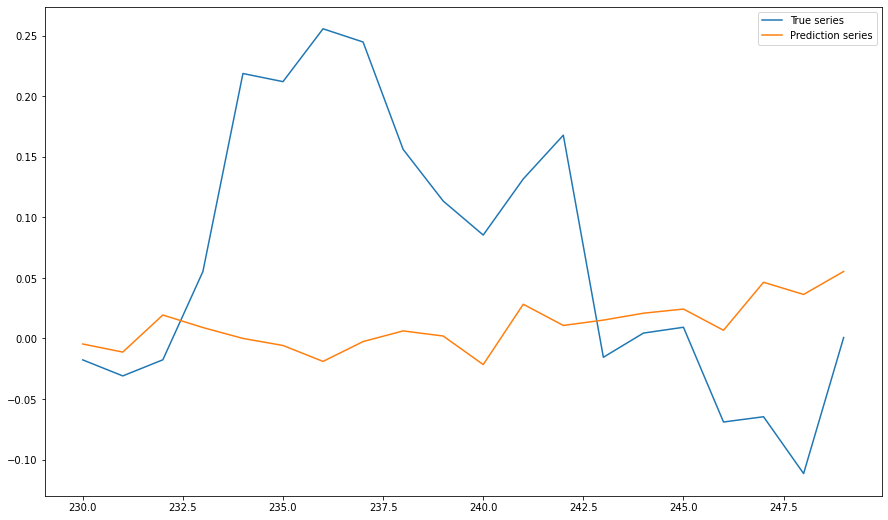

MAE is 0.10776378959417343
(20,) (20,)


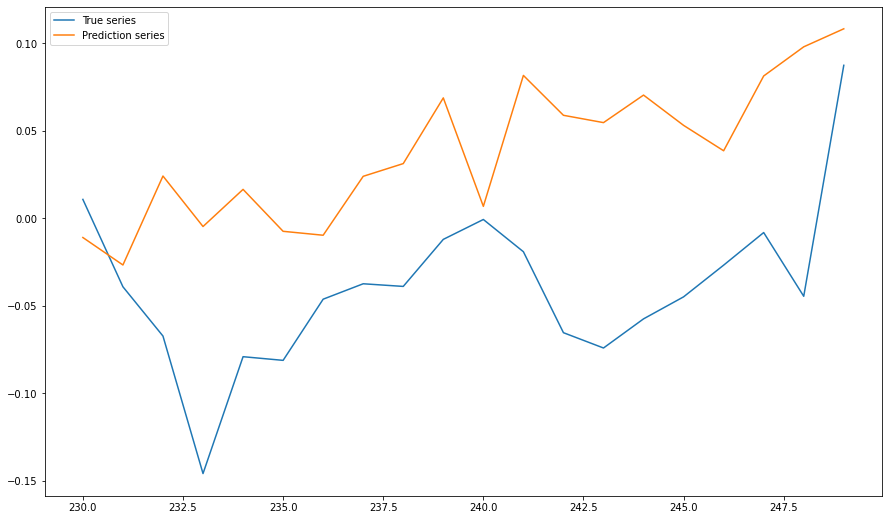

MAE is 0.07956599444150925
(20,) (20,)


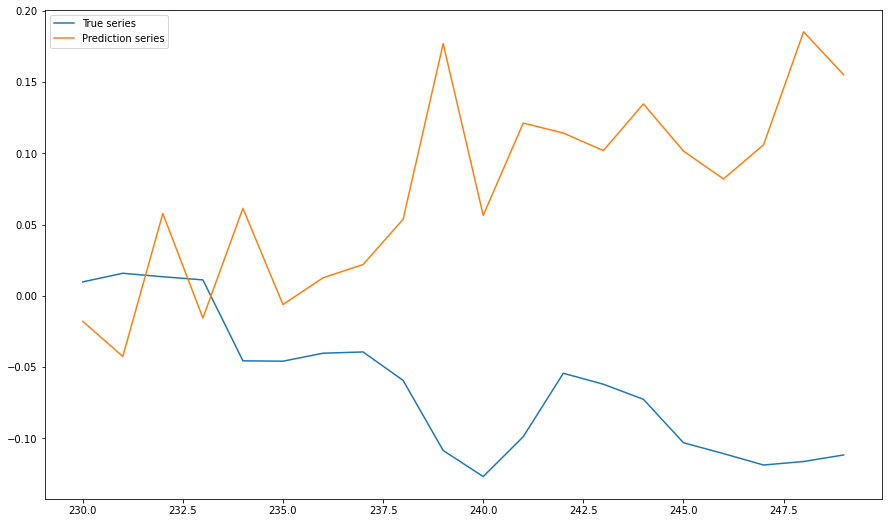

MAE is 0.14751562476158142
(20,) (20,)


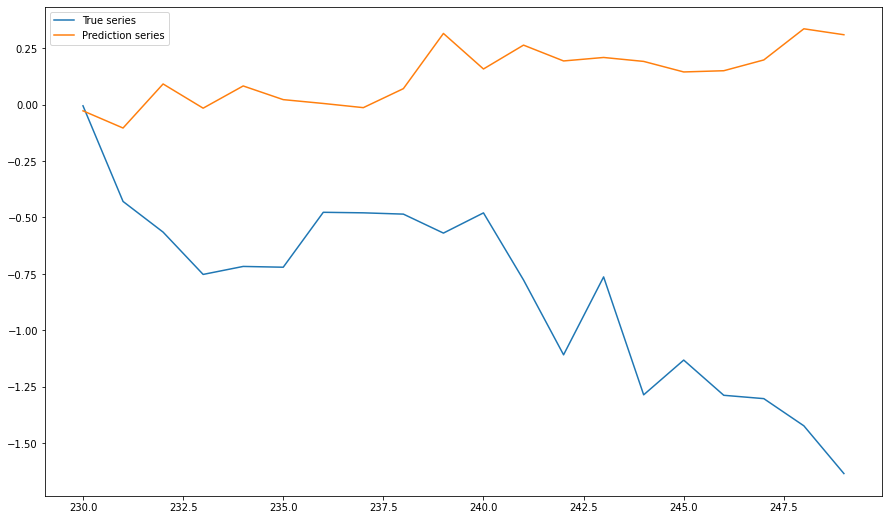

MAE is 0.9513055086135864
(20,) (20,)


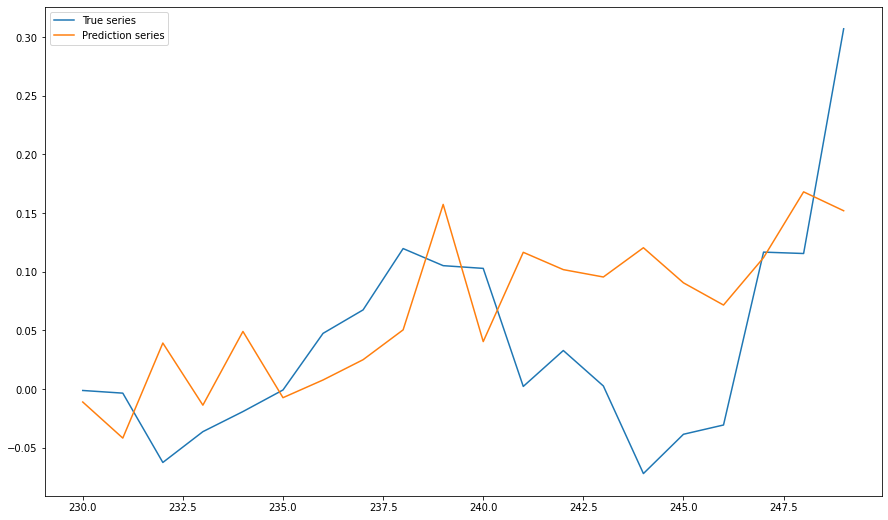

MAE is 0.07129548490047455
(20,) (20,)


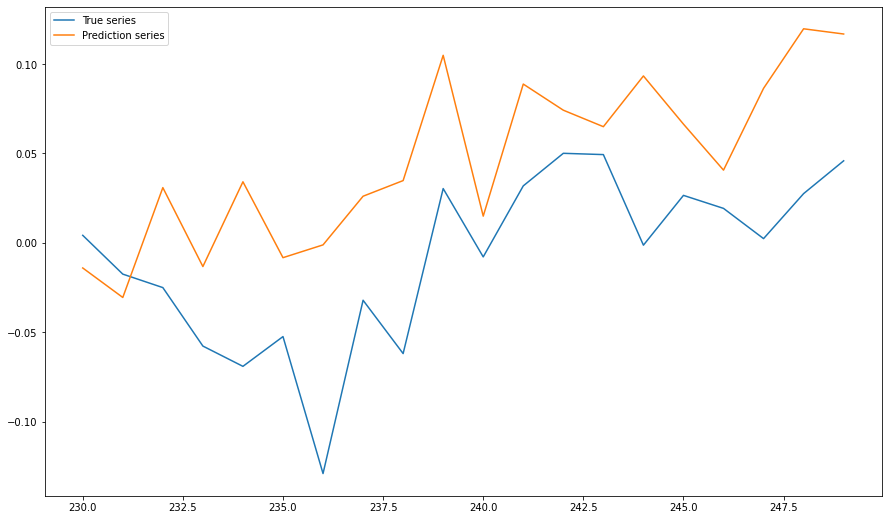

MAE is 0.05796768143773079
(20,) (20,)


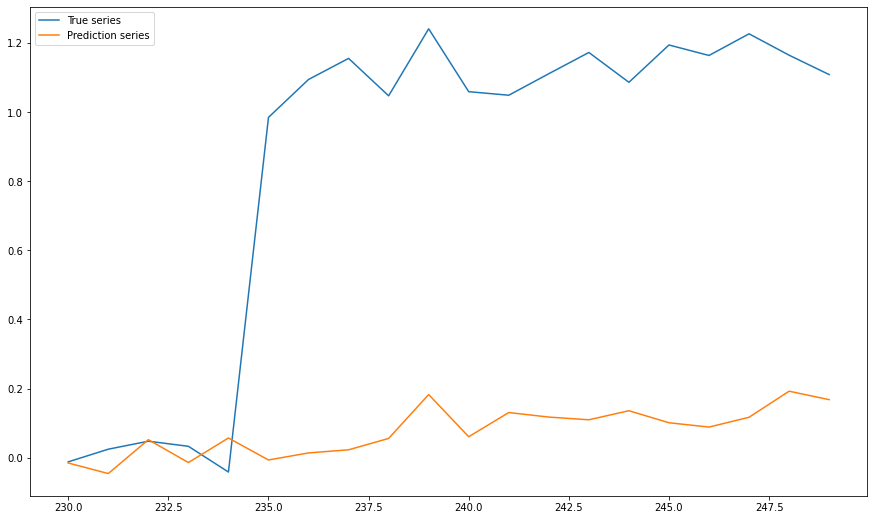

MAE is 0.7791908979415894
(20,) (20,)


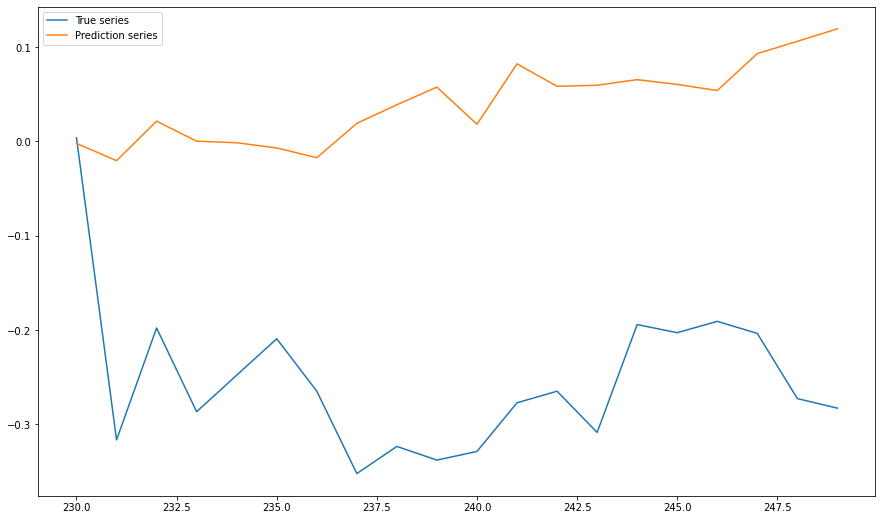

MAE is 0.2938603162765503
(20,) (20,)


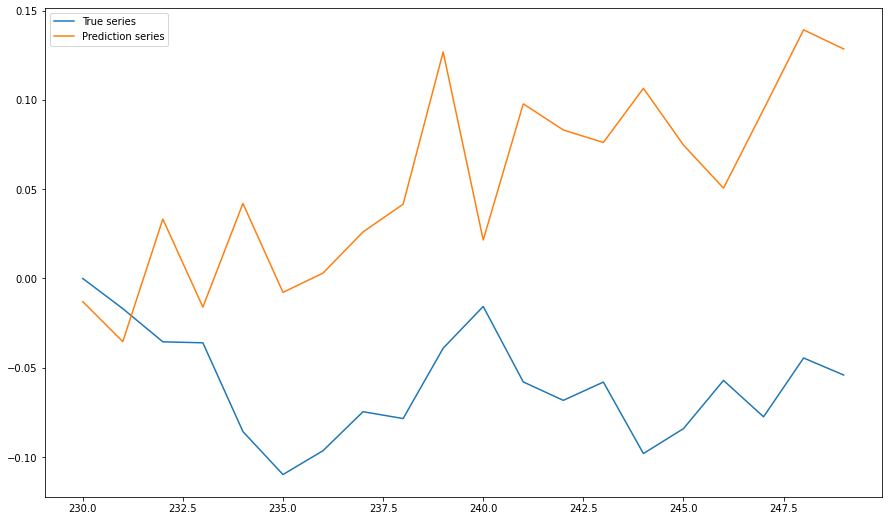

MAE is 0.11623705923557281
(20,) (20,)


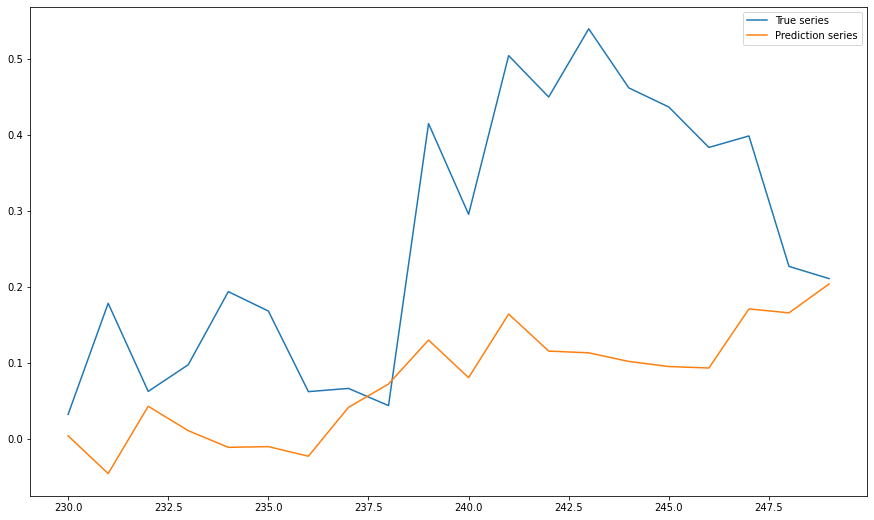

MAE is 0.1883164644241333
(20,) (20,)


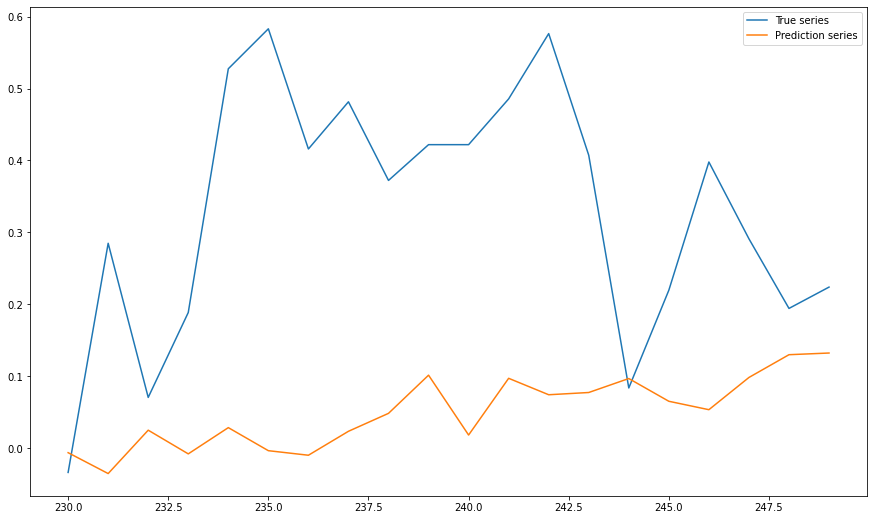

MAE is 0.2843492925167084
(20,) (20,)


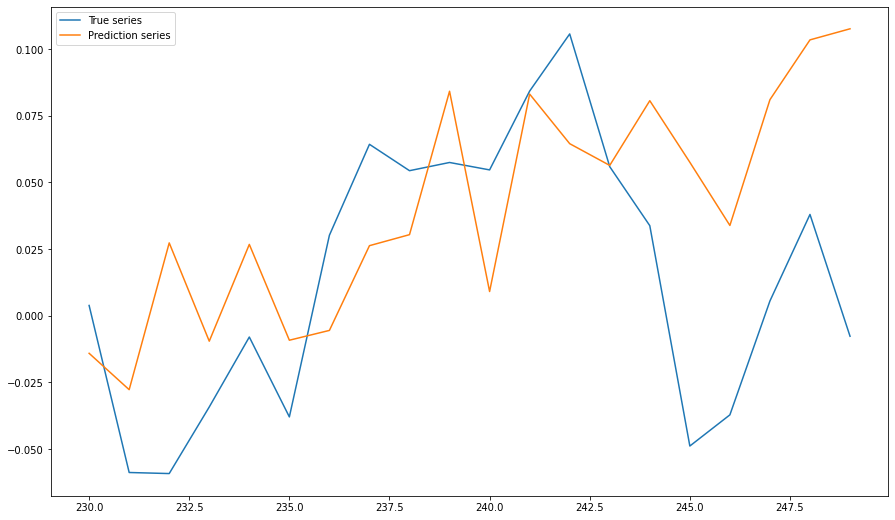

MAE is 0.04585522040724754
(20,) (20,)


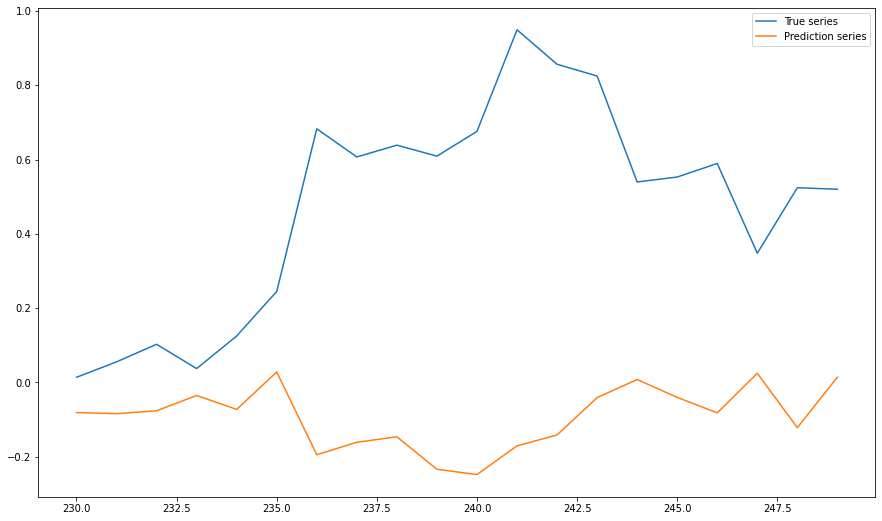

MAE is 0.5677810907363892
(20,) (20,)


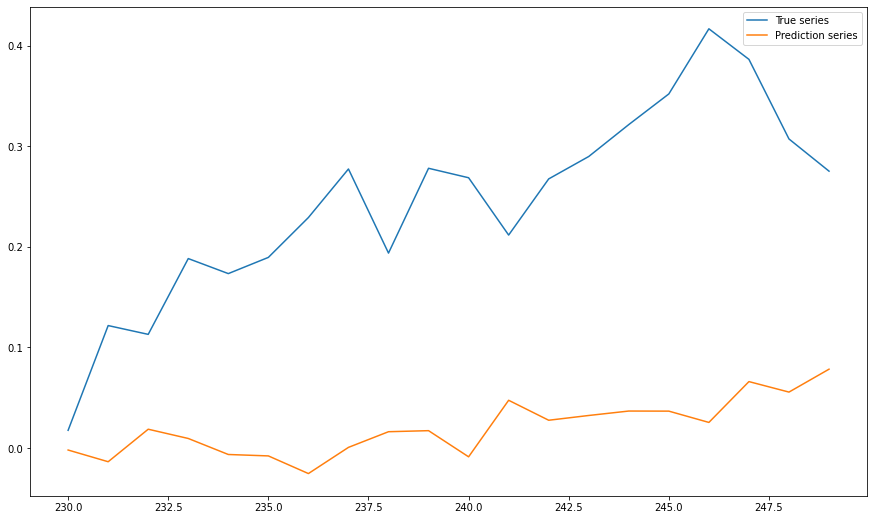

MAE is 0.22371380031108856
(20,) (20,)


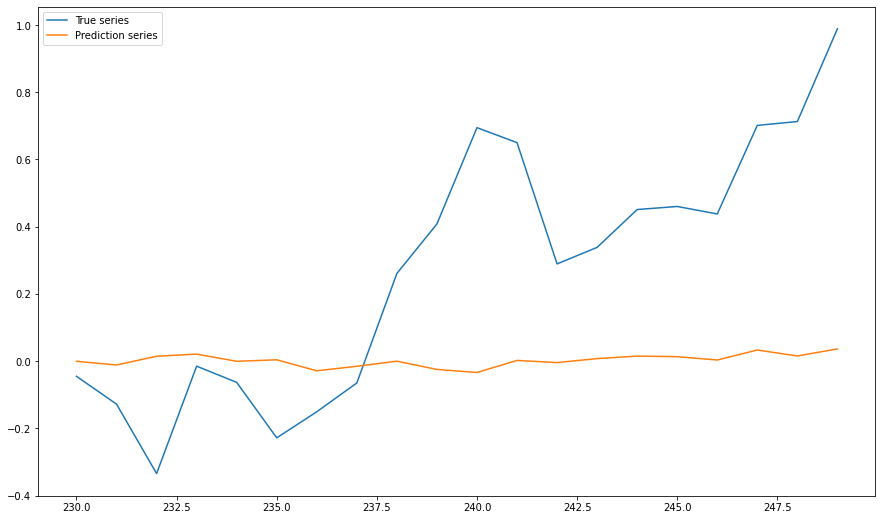

MAE is 0.36702579259872437
(20,) (20,)


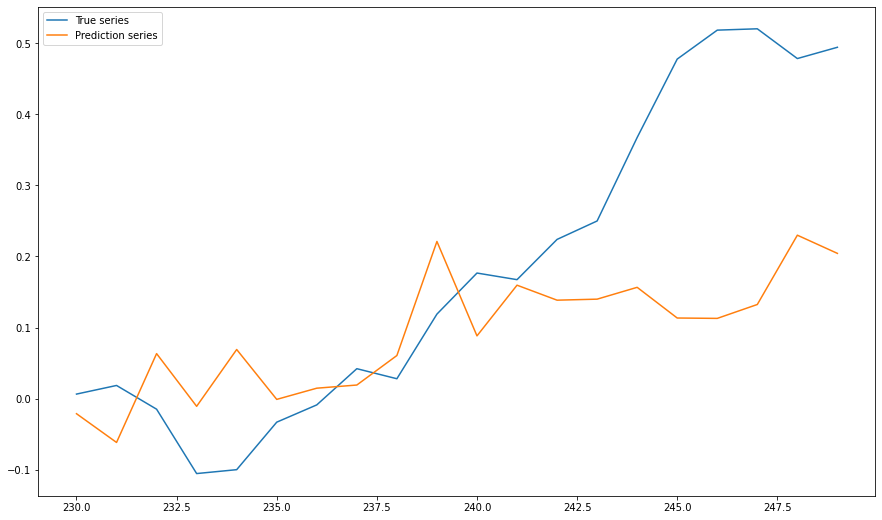

MAE is 0.1430642455816269
(20,) (20,)


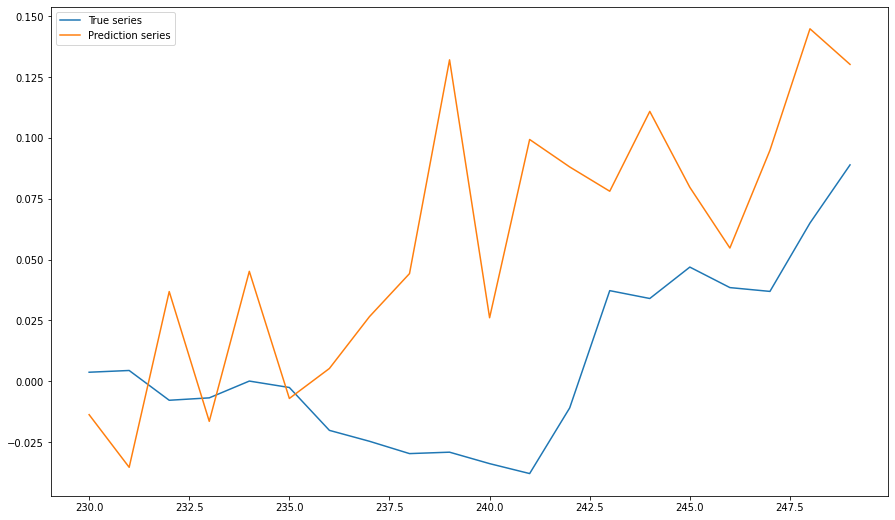

MAE is 0.05572953075170517
(20,) (20,)


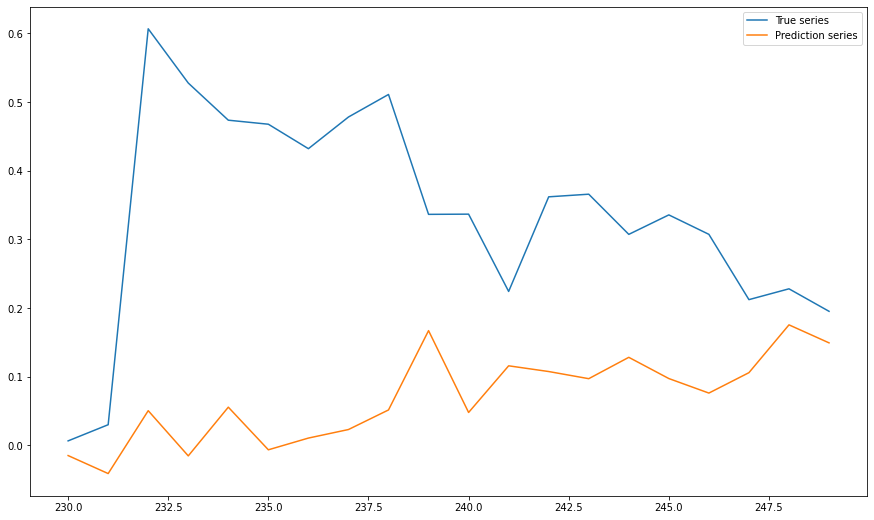

MAE is 0.2680950164794922
(20,) (20,)


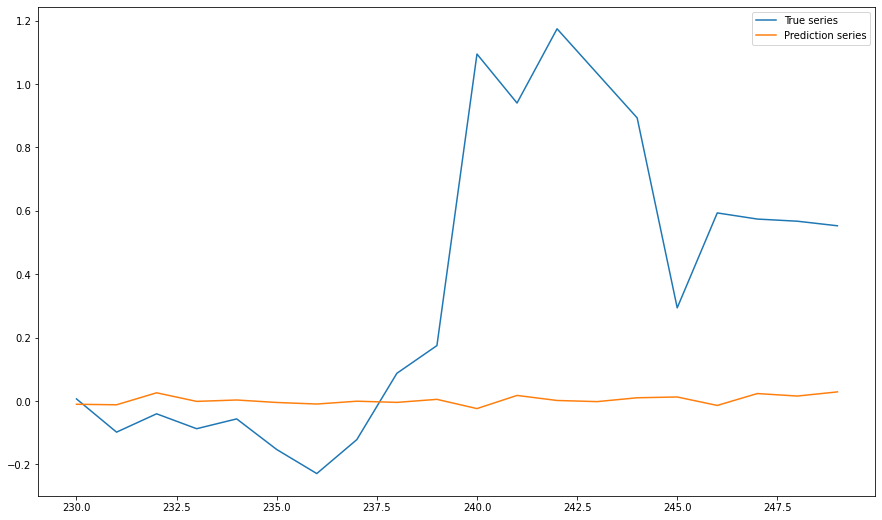

MAE is 0.43554988503456116
(20,) (20,)


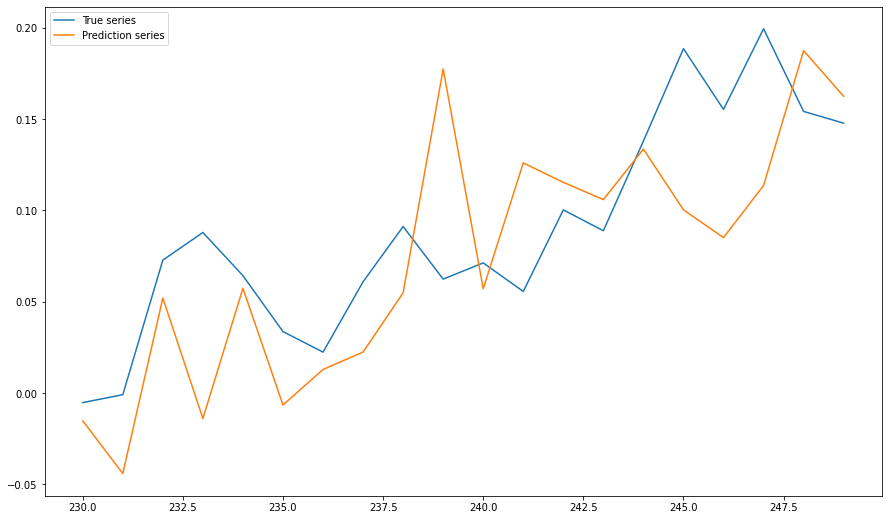

MAE is 0.04177131503820419
(20,) (20,)


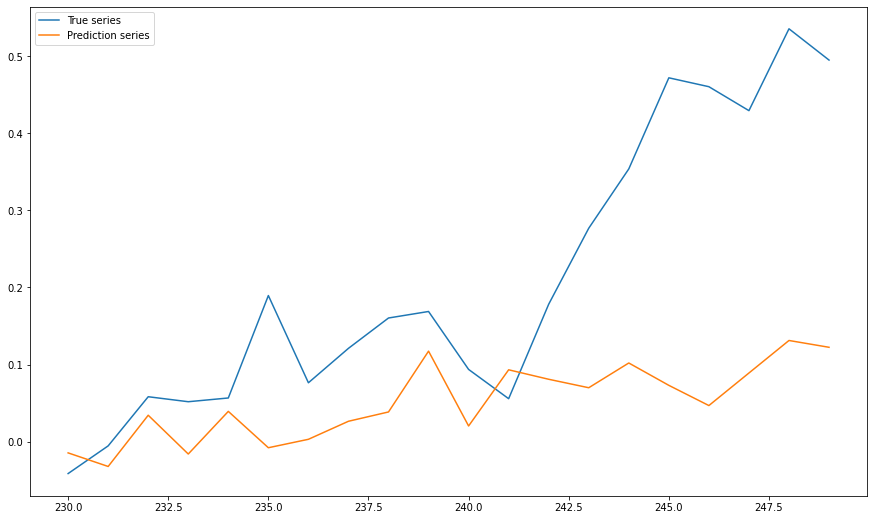

MAE is 0.16482968628406525
(20,) (20,)


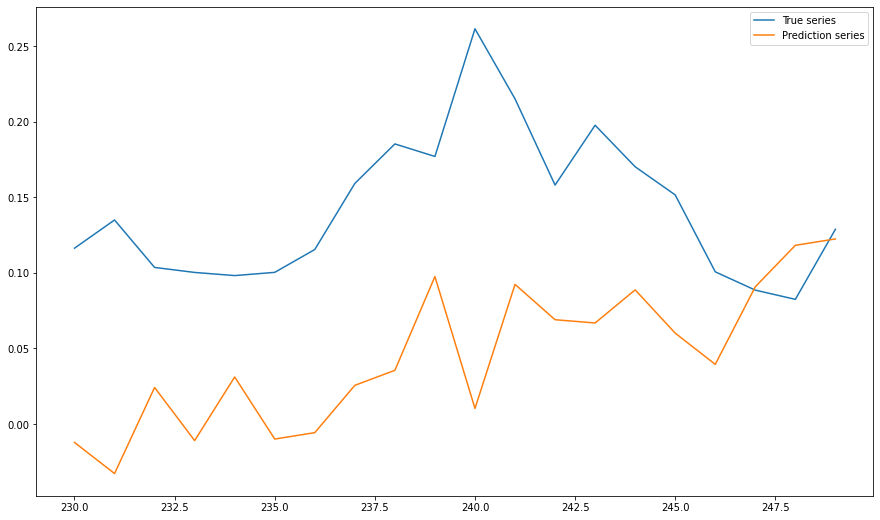

MAE is 0.10100351274013519
(20,) (20,)


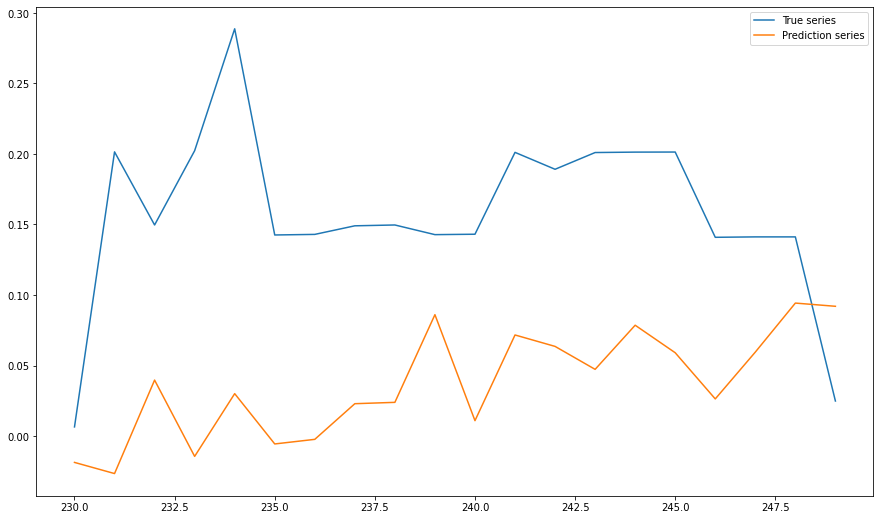

MAE is 0.12781885266304016
(20,) (20,)


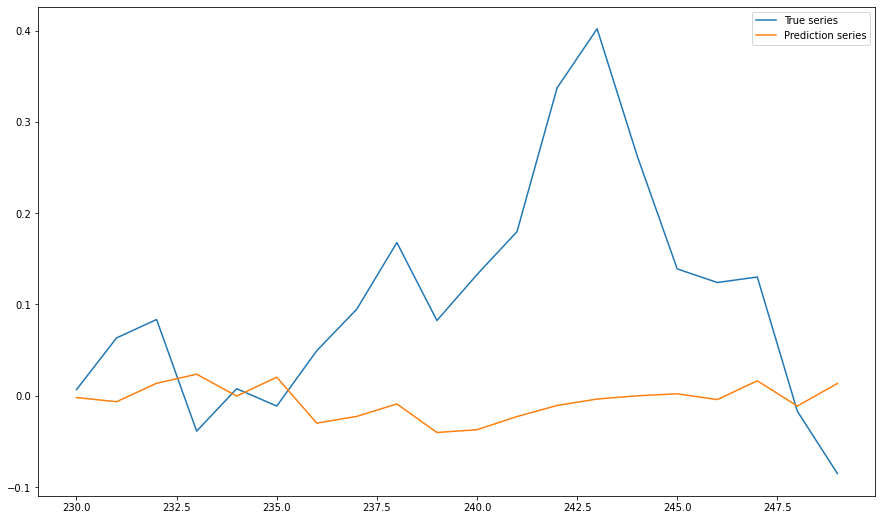

MAE is 0.13090839982032776
(20,) (20,)


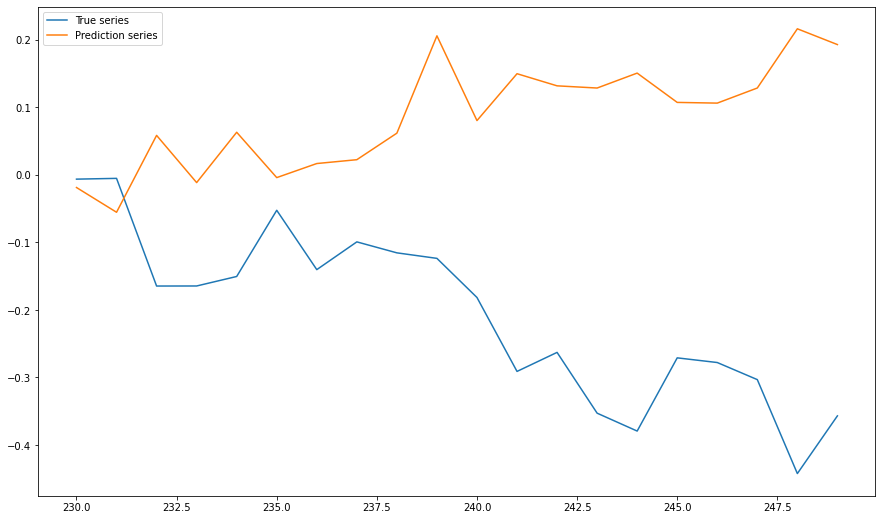

MAE is 0.2998506724834442
(20,) (20,)


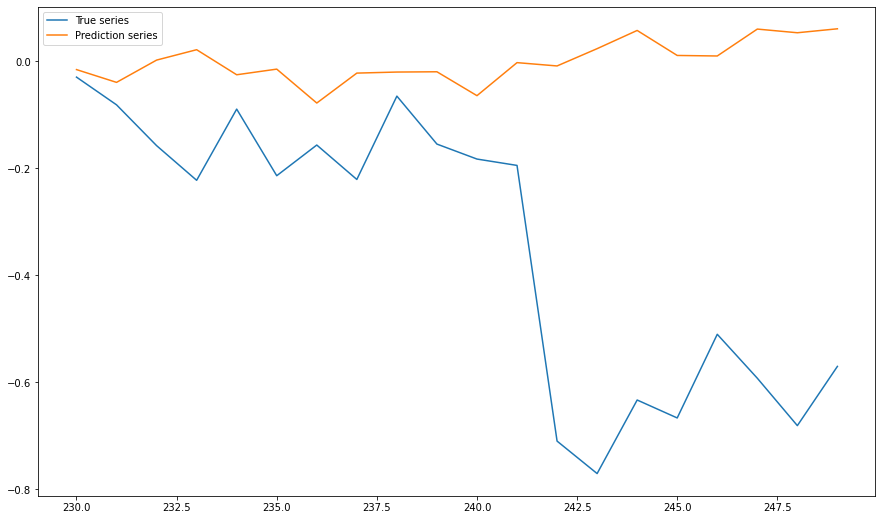

MAE is 0.3448581099510193
(20,) (20,)


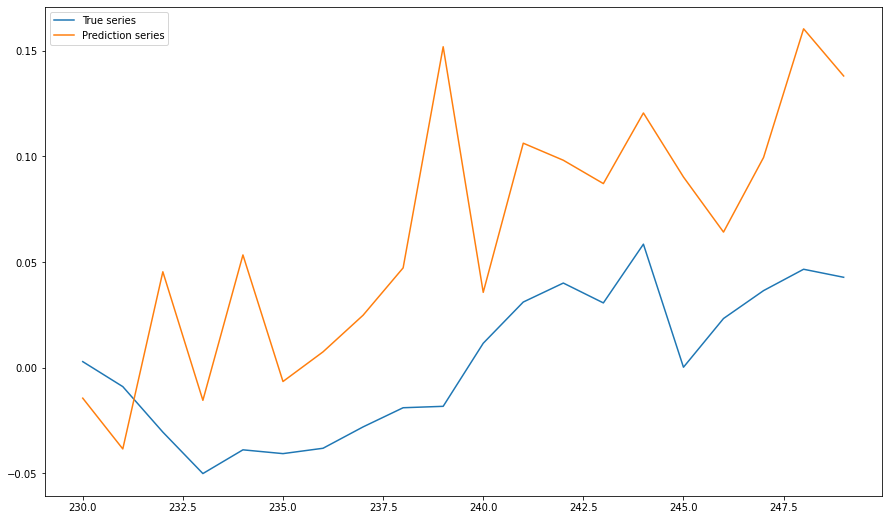

MAE is 0.06483937799930573
(20,) (20,)


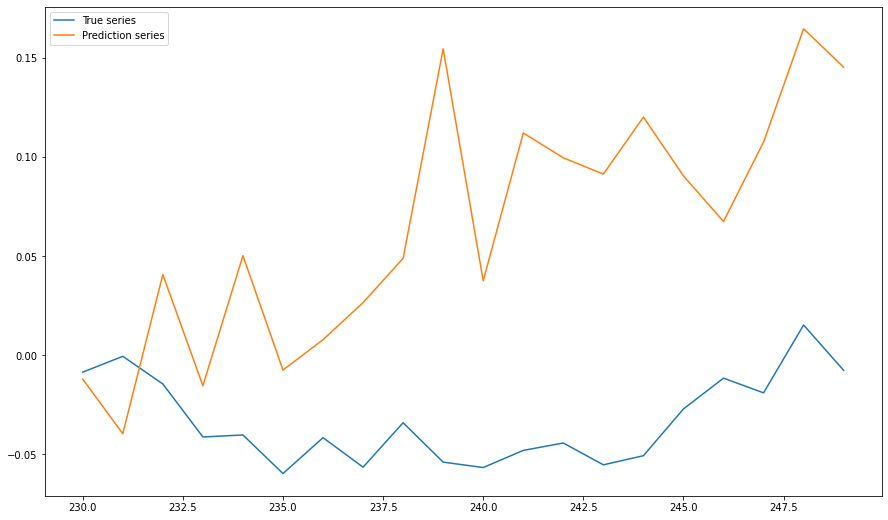

MAE is 0.10144128650426865
(20,) (20,)


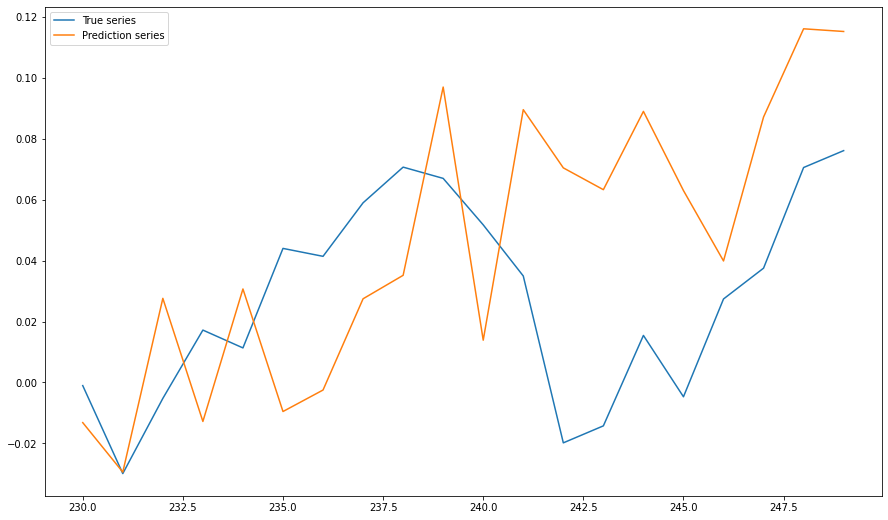

MAE is 0.041861243546009064
(20,) (20,)


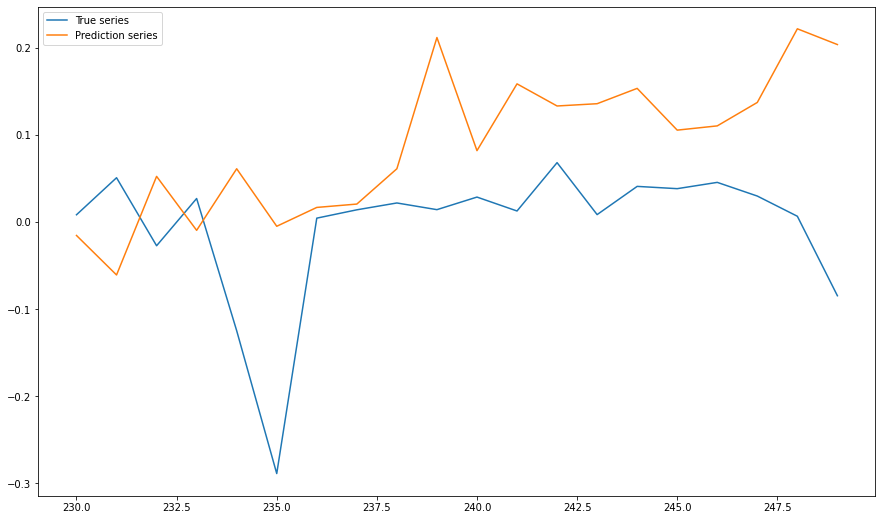

MAE is 0.11123557388782501
(20,) (20,)


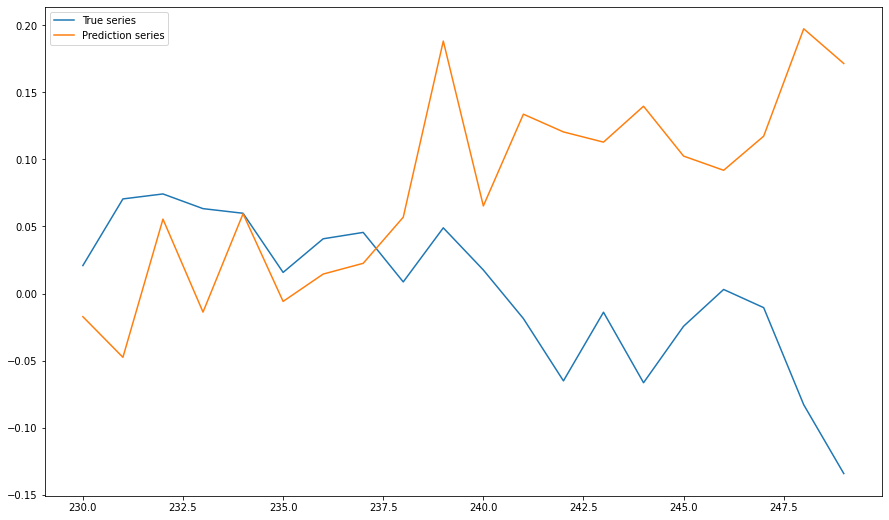

MAE is 0.10792644321918488
(20,) (20,)


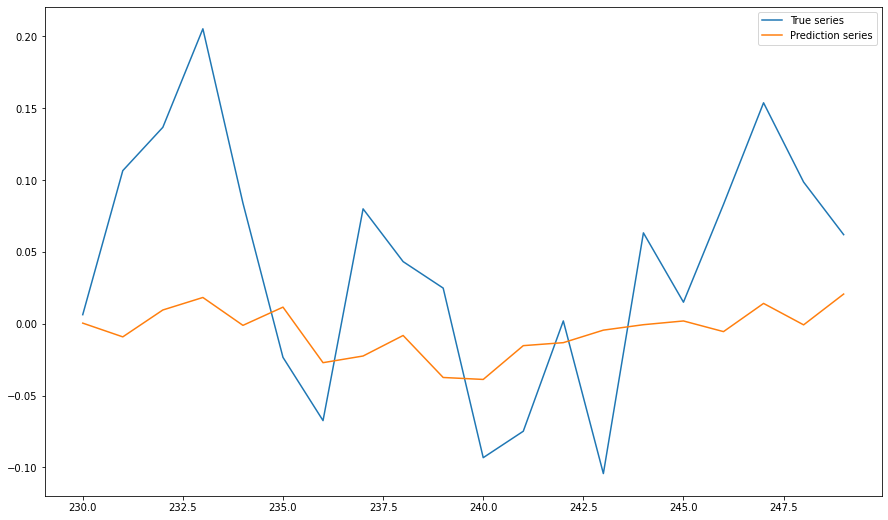

MAE is 0.07430621236562729
(20,) (20,)


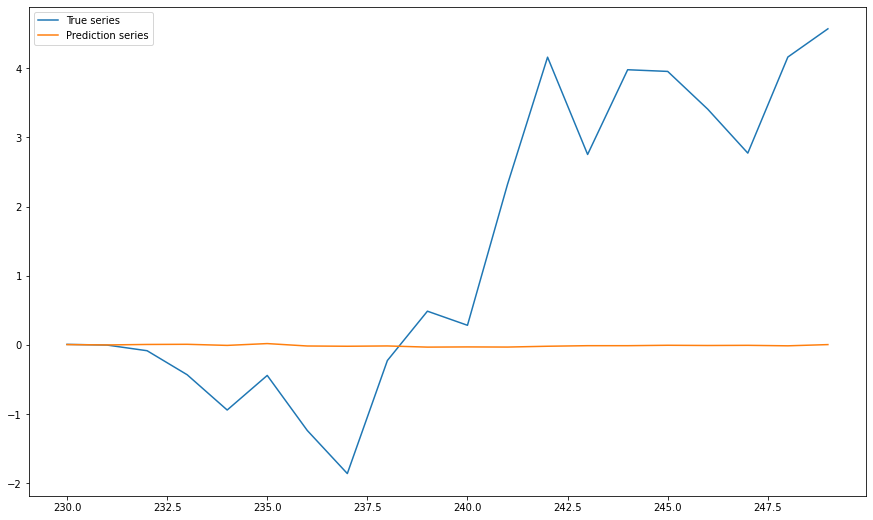

MAE is 1.911974549293518
(20,) (20,)


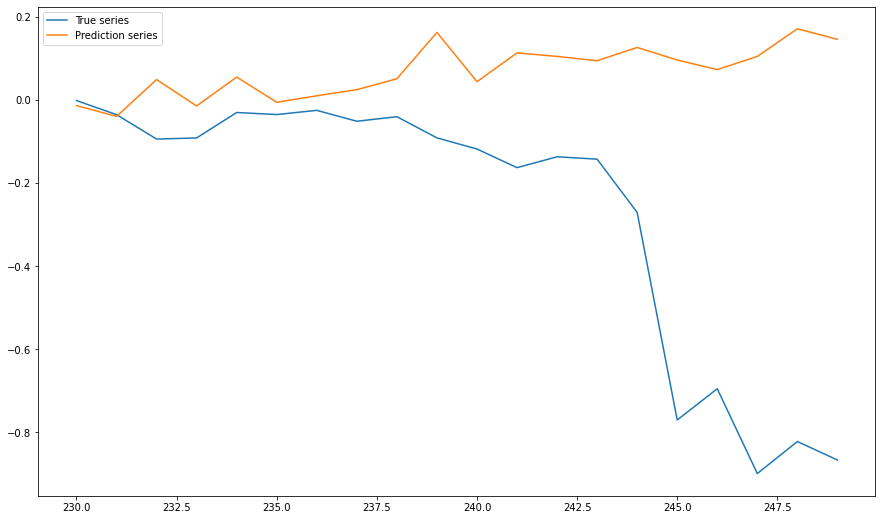

MAE is 0.33816173672676086
(20,) (20,)


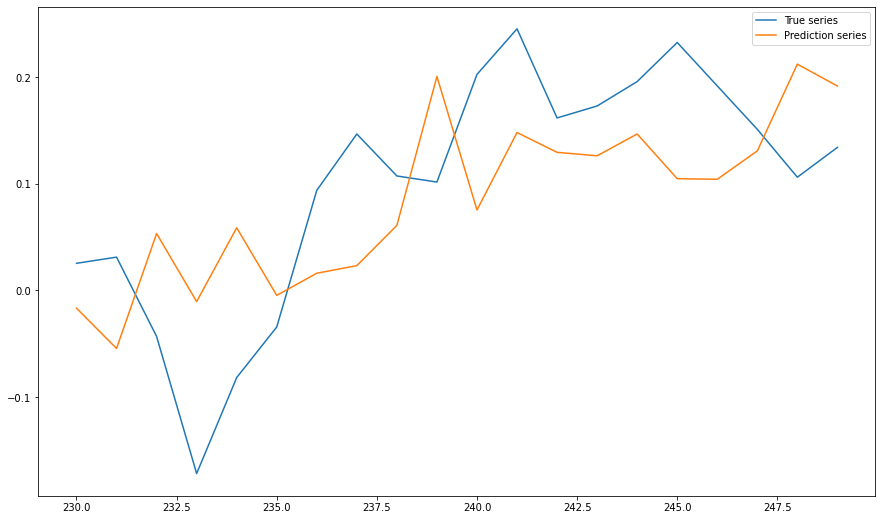

MAE is 0.08258237689733505
(20,) (20,)


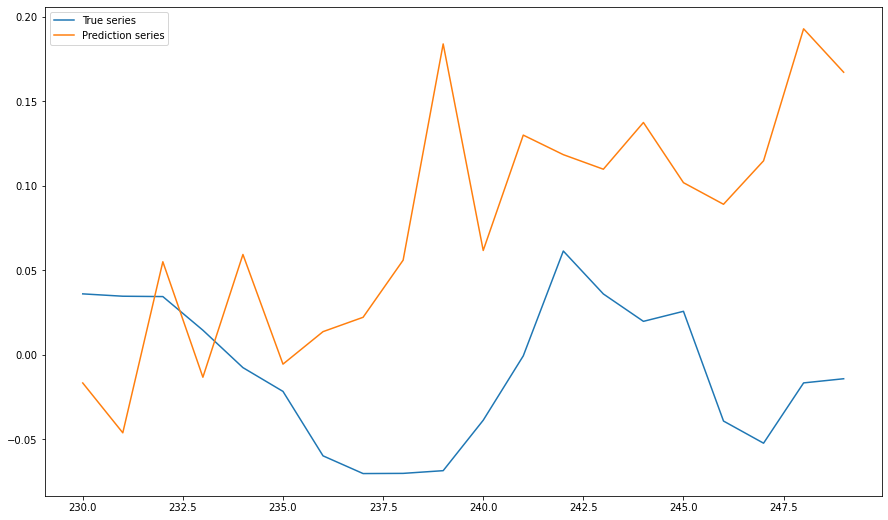

MAE is 0.10261183977127075
(20,) (20,)


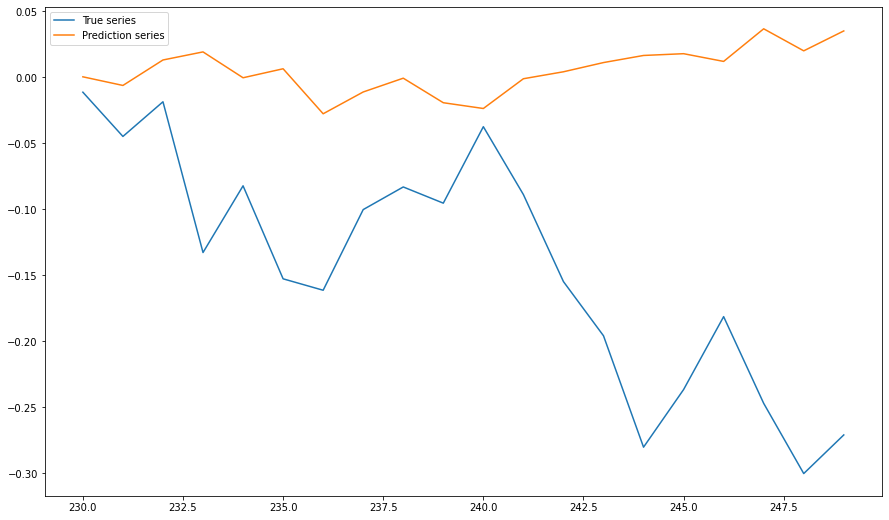

MAE is 0.14887657761573792
(20,) (20,)


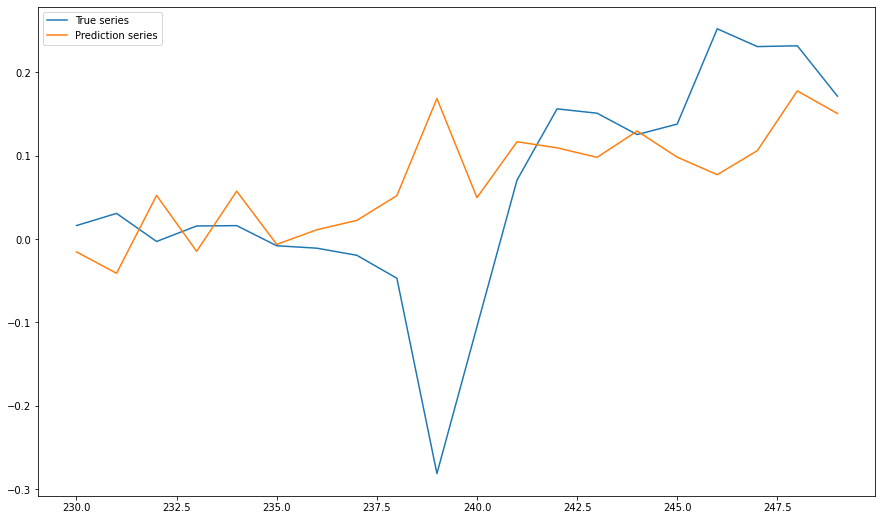

MAE is 0.0781886875629425
(20,) (20,)


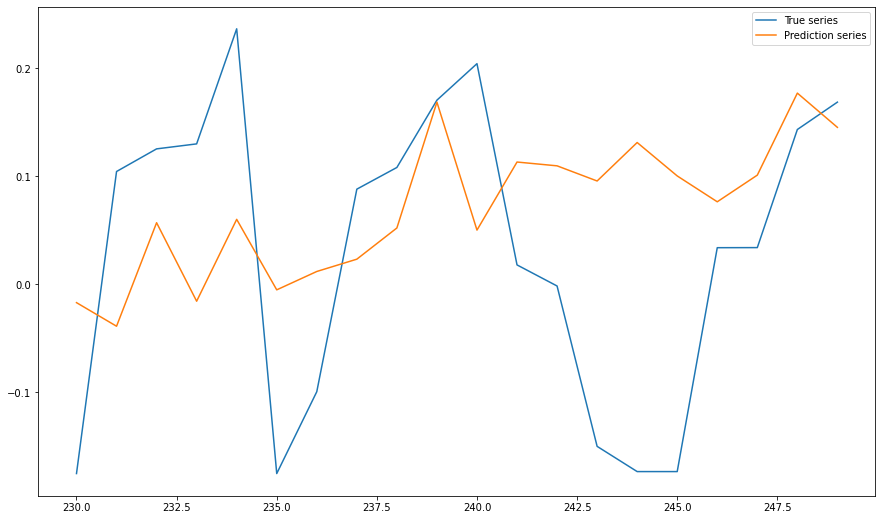

MAE is 0.12247087061405182
(20,) (20,)


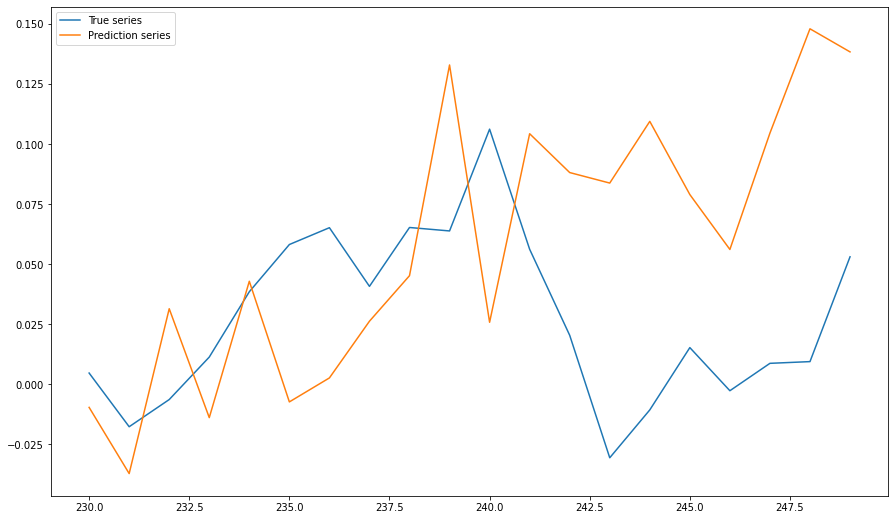

MAE is 0.0603007897734642
(20,) (20,)


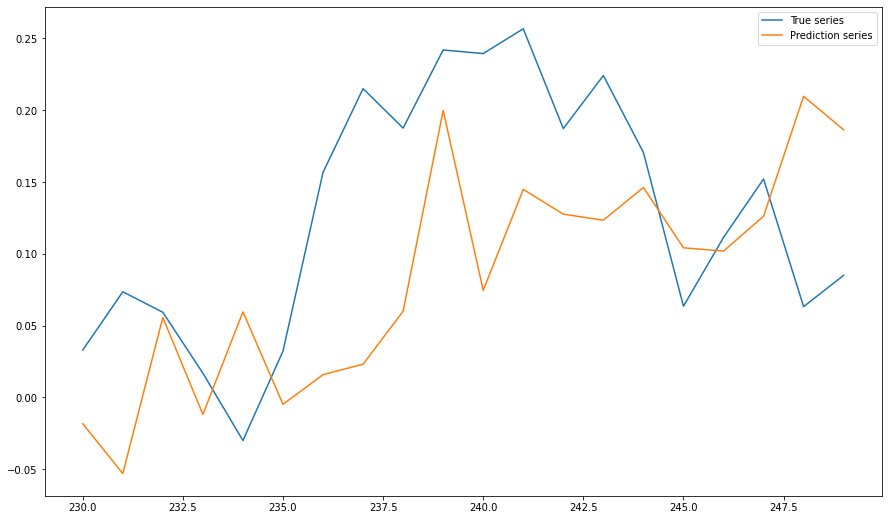

MAE is 0.0812191441655159
(20,) (20,)


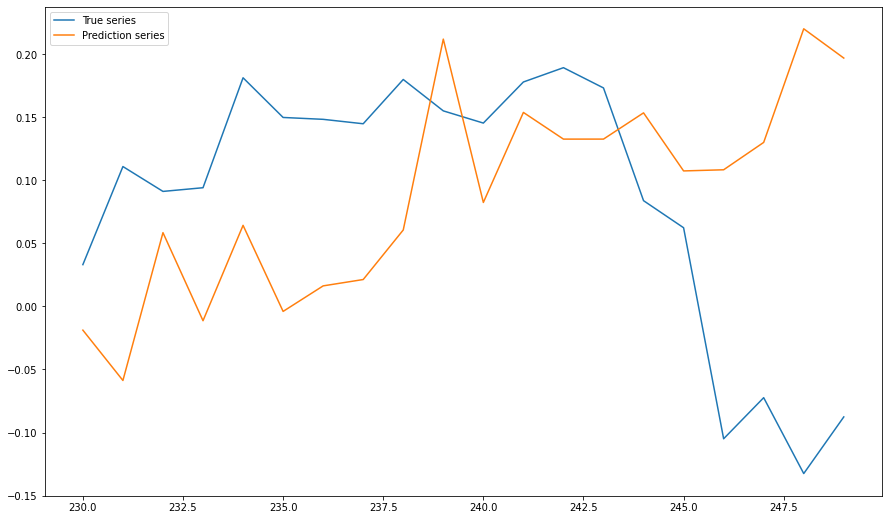

MAE is 0.12058617174625397
(20,) (20,)


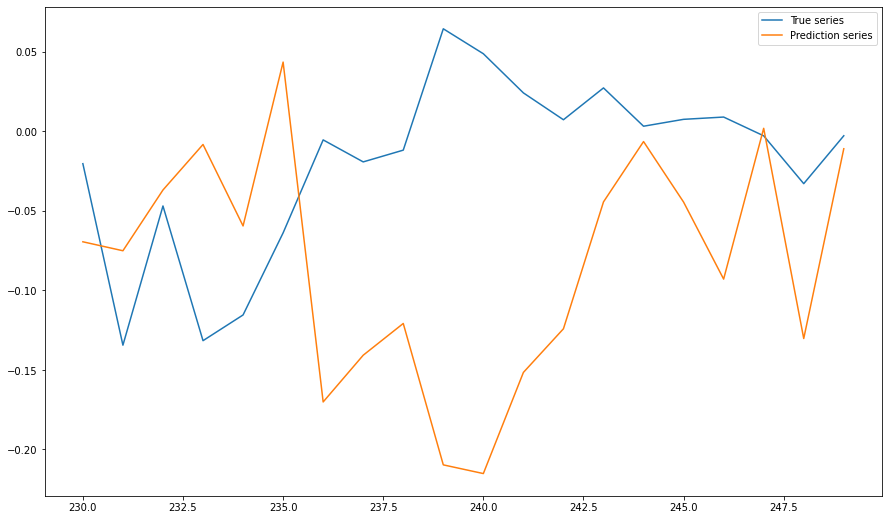

MAE is 0.09948386251926422
(20,) (20,)


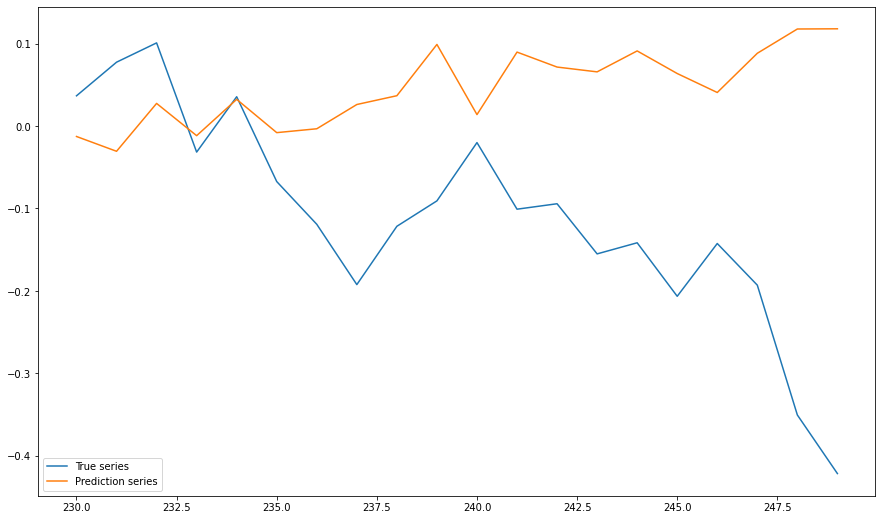

MAE is 0.1791372299194336
(20,) (20,)


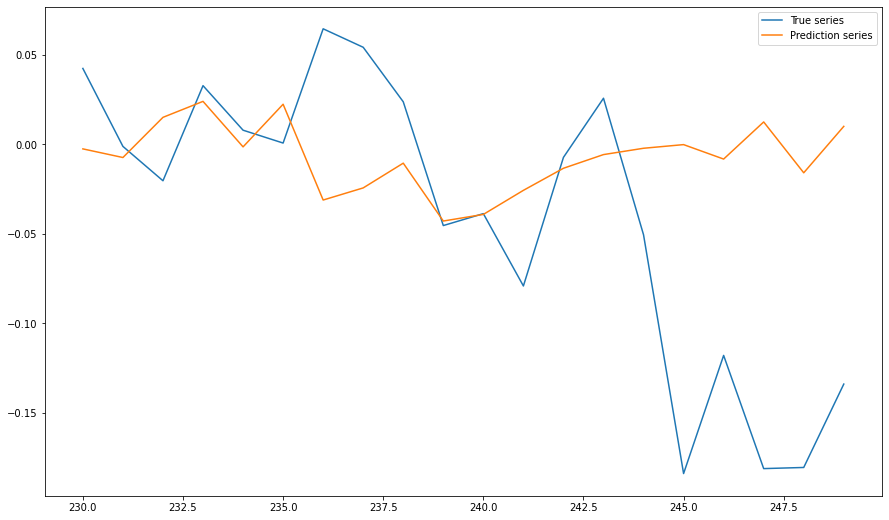

MAE is 0.06362748891115189
(20,) (20,)


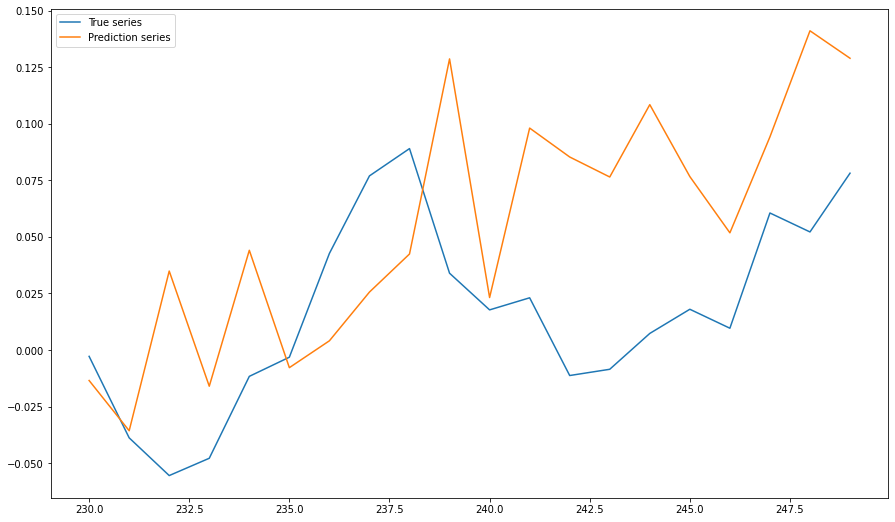

MAE is 0.05324281379580498
(20,) (20,)


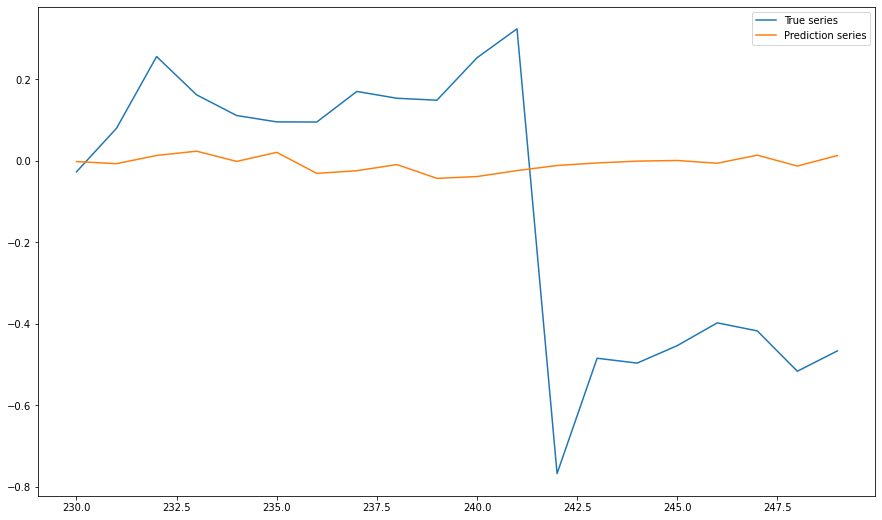

MAE is 0.29925745725631714
(20,) (20,)


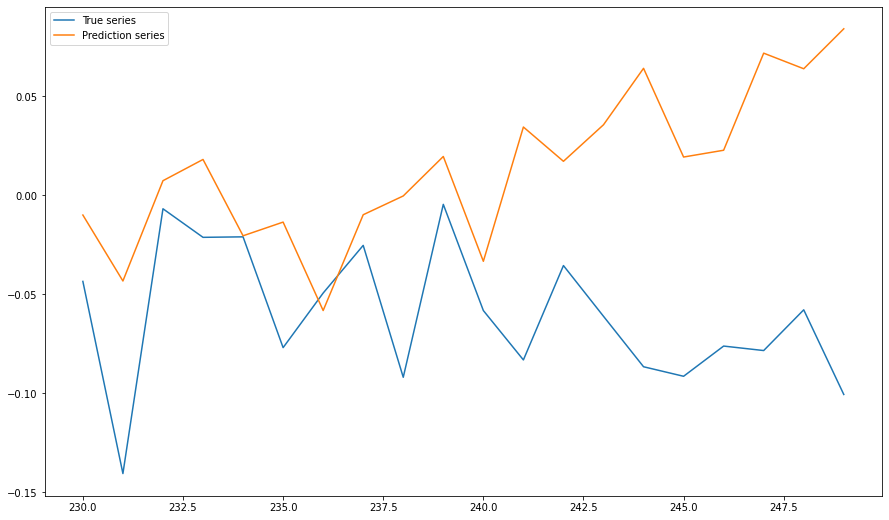

MAE is 0.07487409561872482
(20,) (20,)


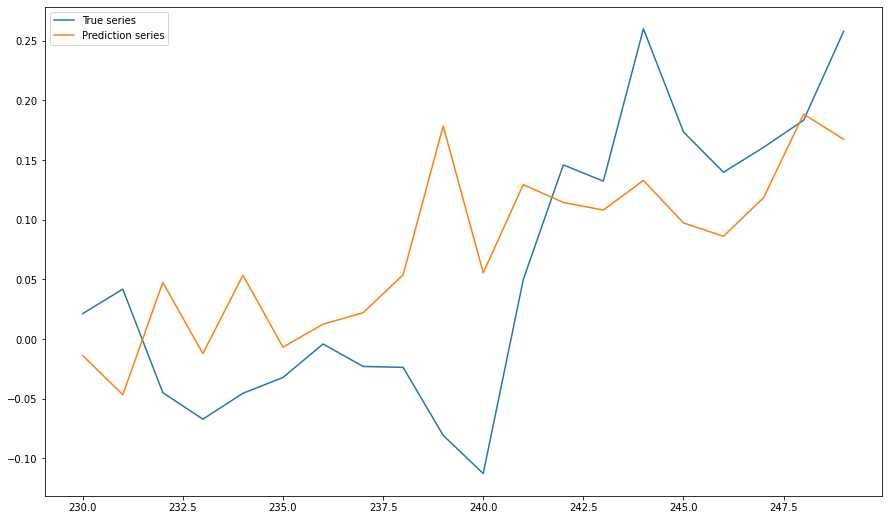

MAE is 0.07464087009429932
(20,) (20,)


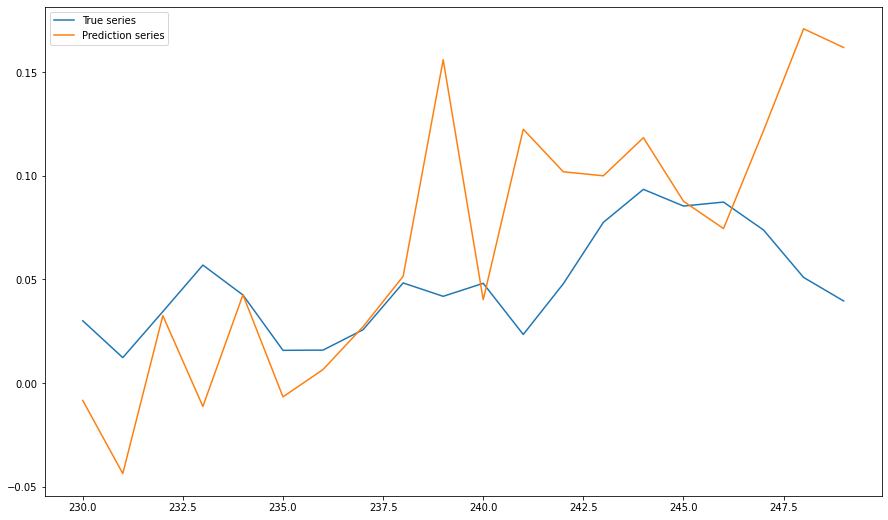

MAE is 0.04145063832402229
(20,) (20,)


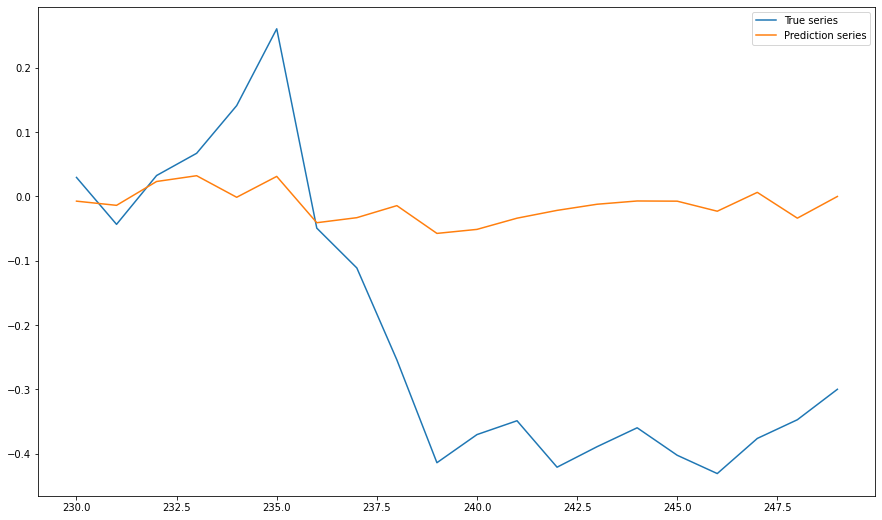

MAE is 0.23630478978157043
(20,) (20,)


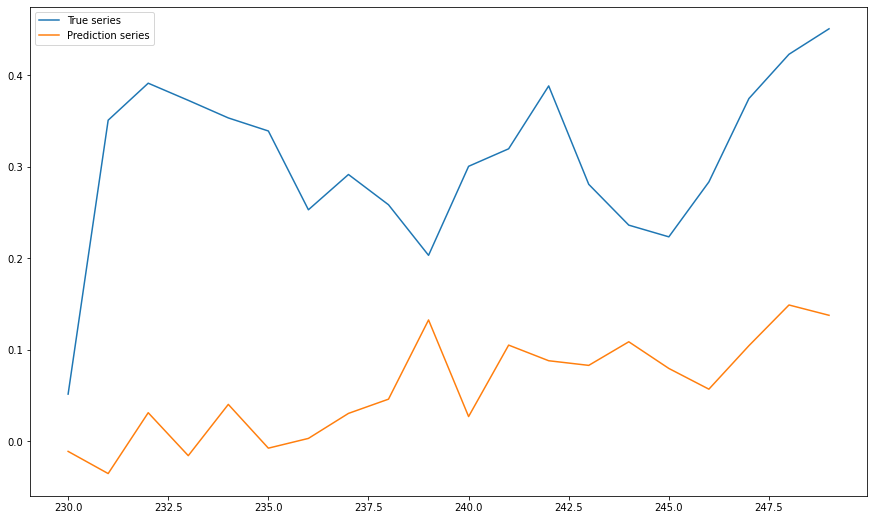

MAE is 0.24942758679389954
(20,) (20,)


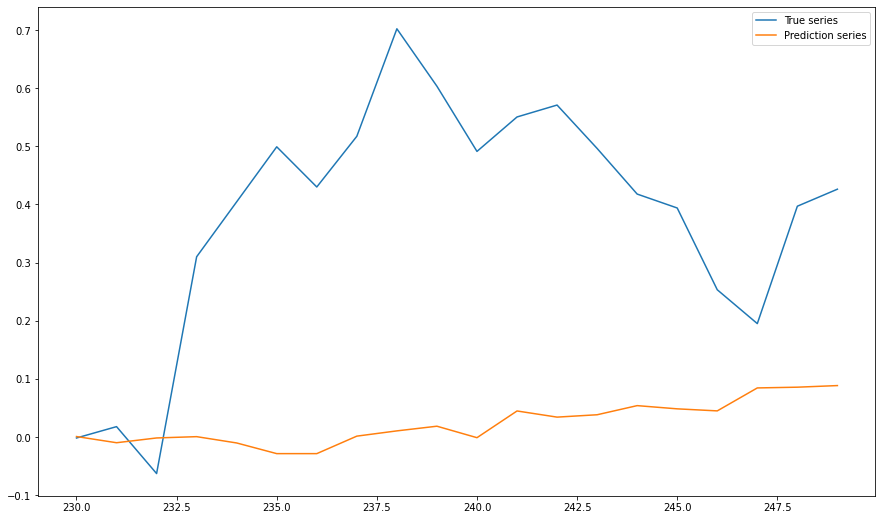

MAE is 0.3631851077079773
(20,) (20,)


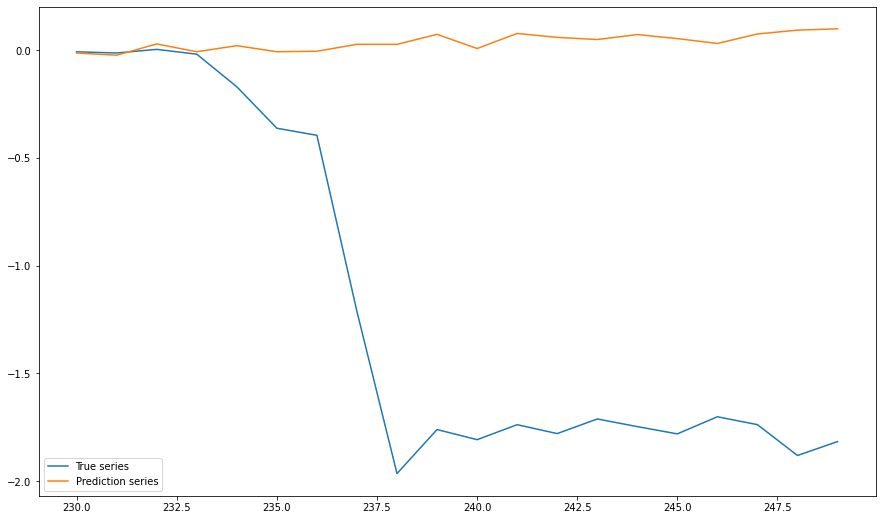

MAE is 1.2176804542541504
(20,) (20,)


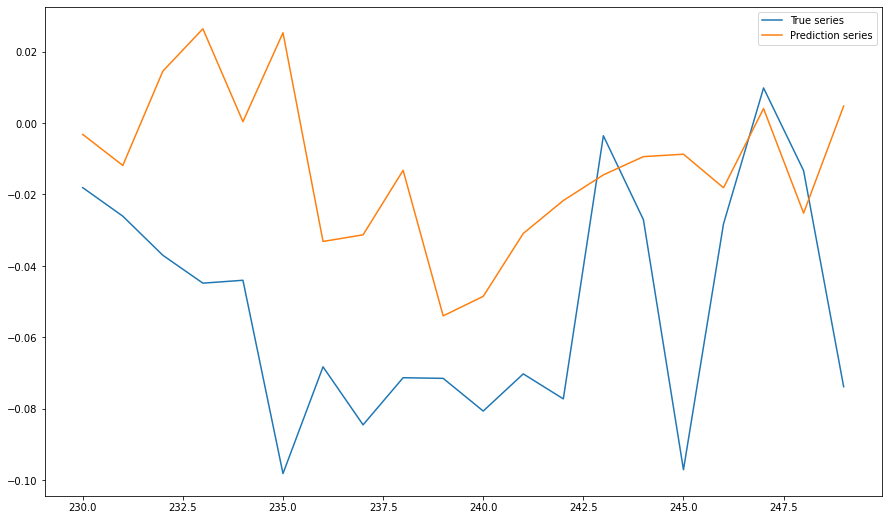

MAE is 0.04167374595999718
(20,) (20,)


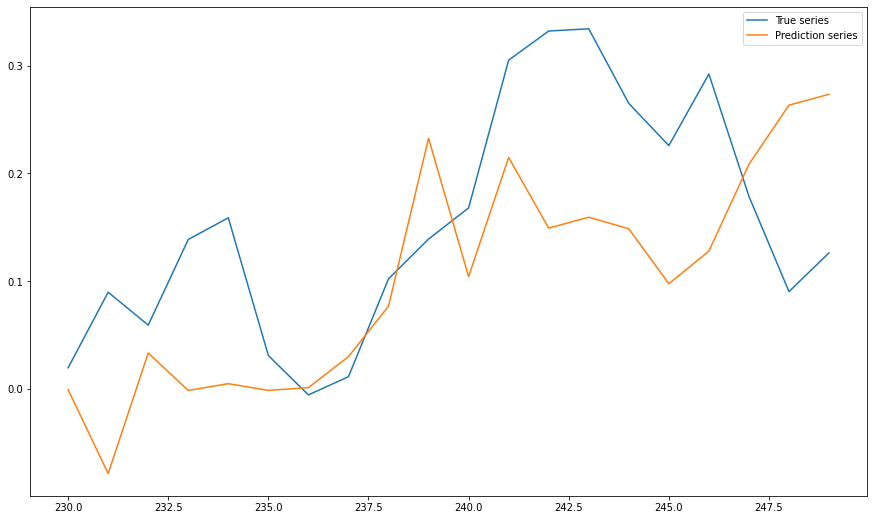

MAE is 0.09789852052927017
(20,) (20,)


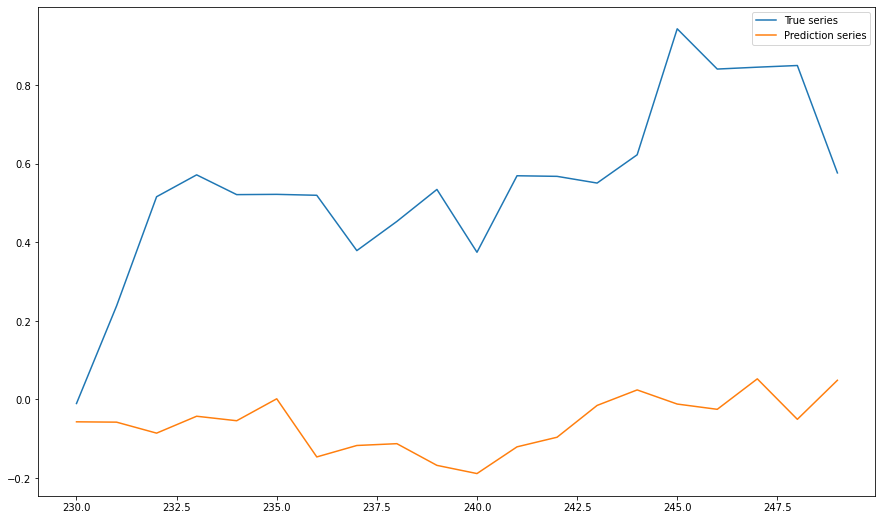

MAE is 0.6103377342224121
(20,) (20,)


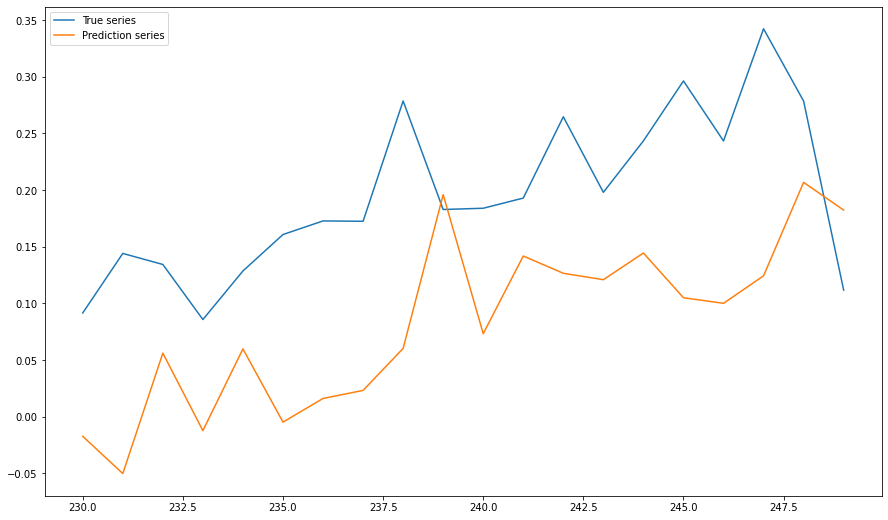

MAE is 0.12107570469379425
(20,) (20,)


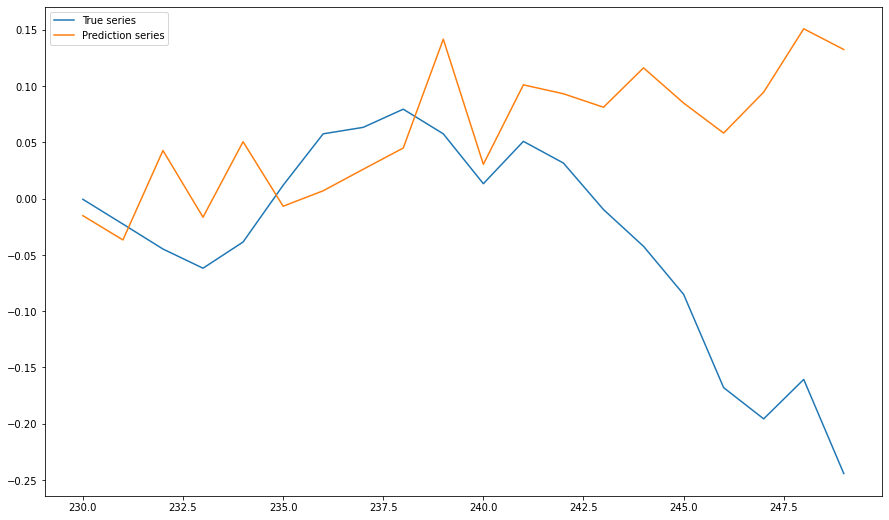

MAE is 0.11141528189182281
(20,) (20,)


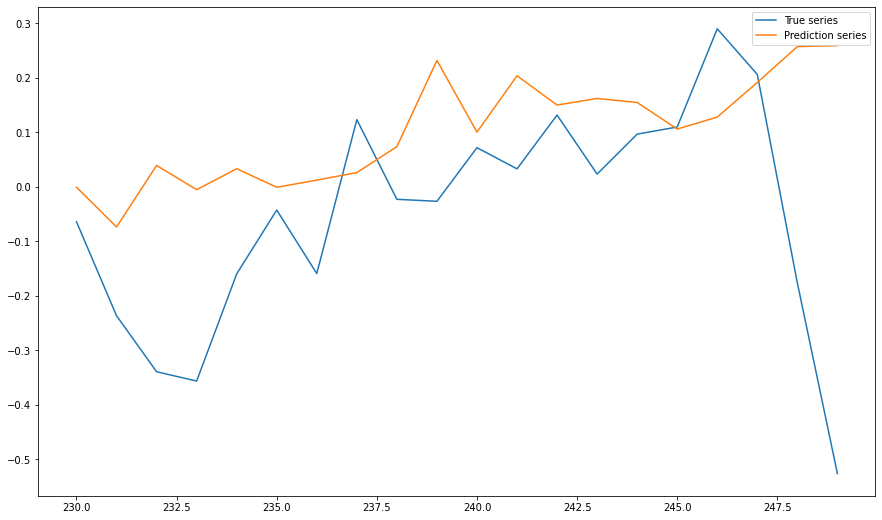

MAE is 0.18132324516773224
(20,) (20,)


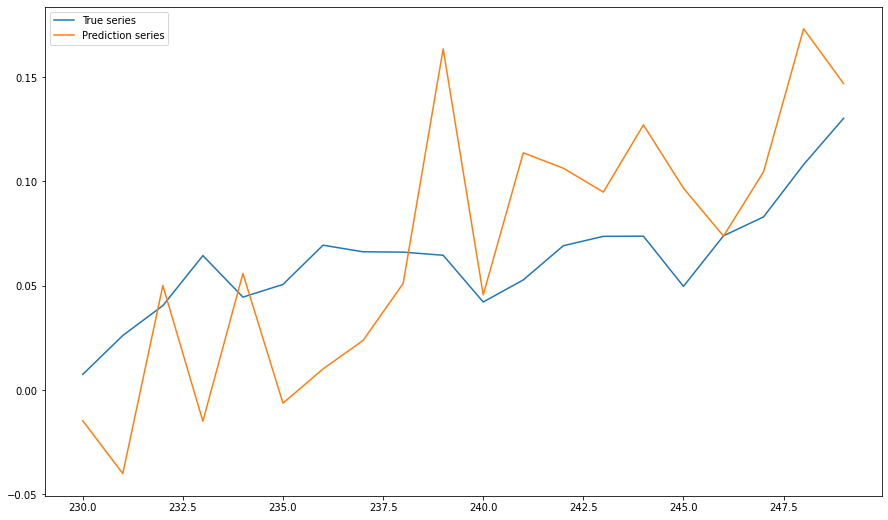

MAE is 0.03941170871257782
(20,) (20,)


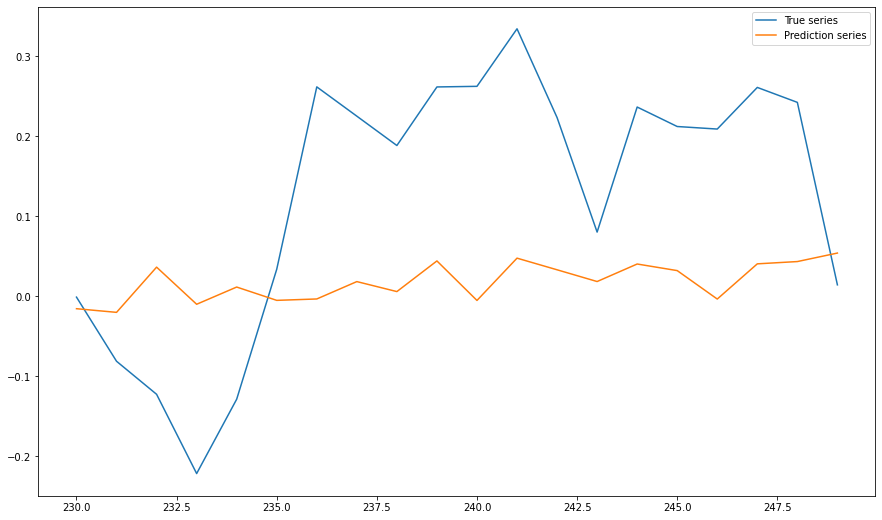

MAE is 0.1677931696176529
(20,) (20,)


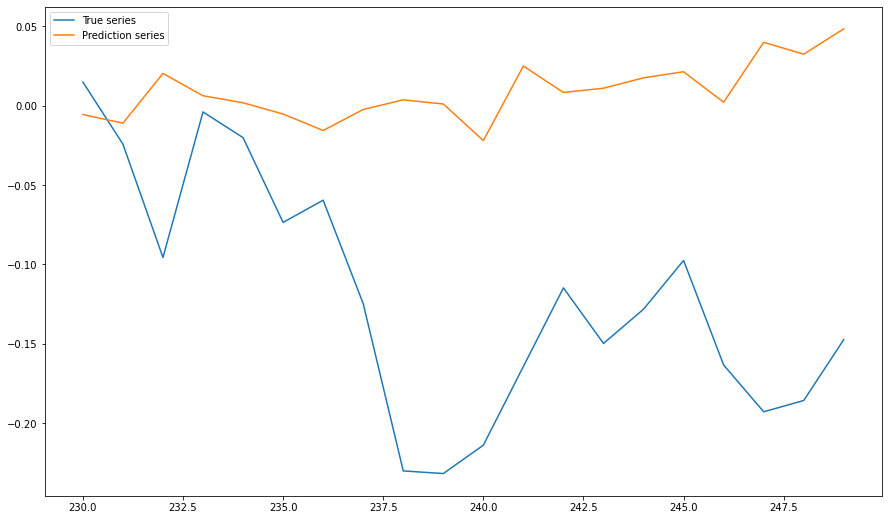

MAE is 0.13128265738487244
(20,) (20,)


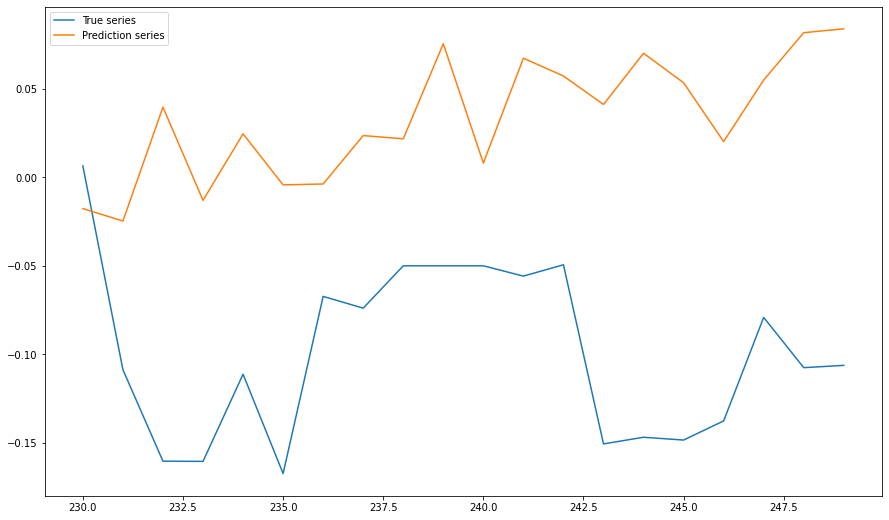

MAE is 0.13416936993598938
(20,) (20,)


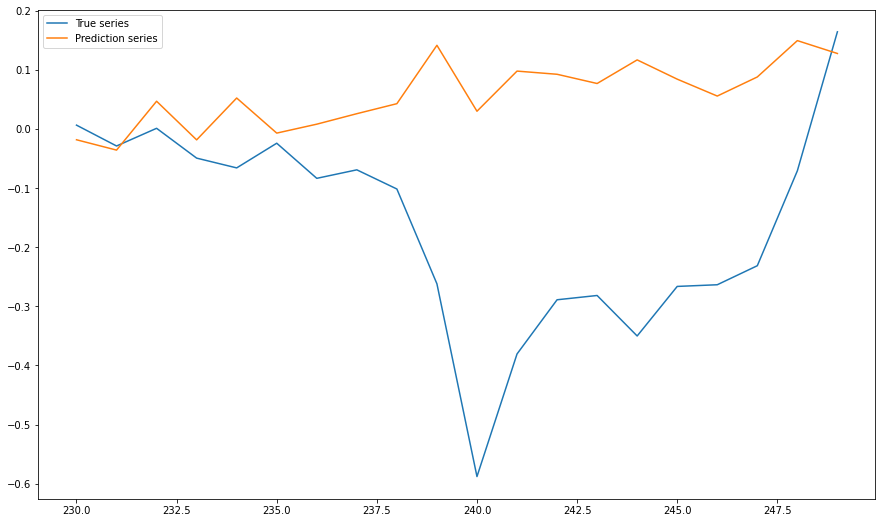

MAE is 0.2263077199459076
(20,) (20,)


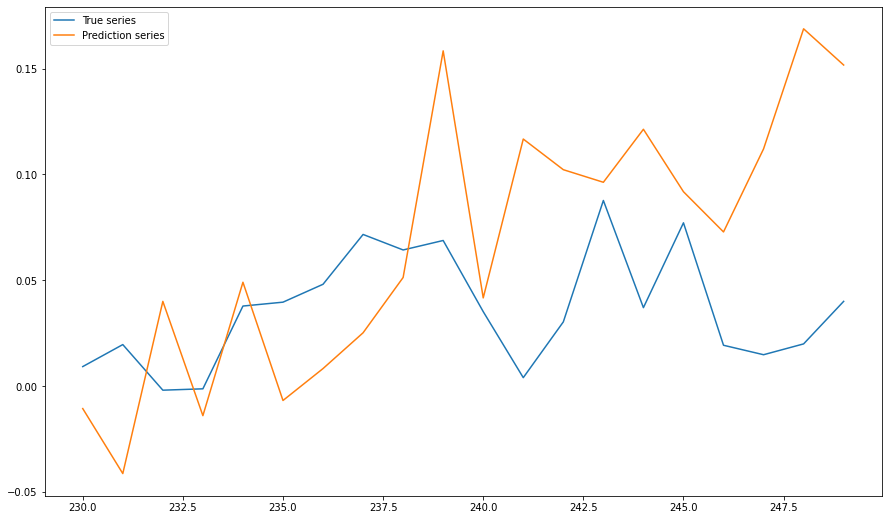

MAE is 0.054659903049468994
(20,) (20,)


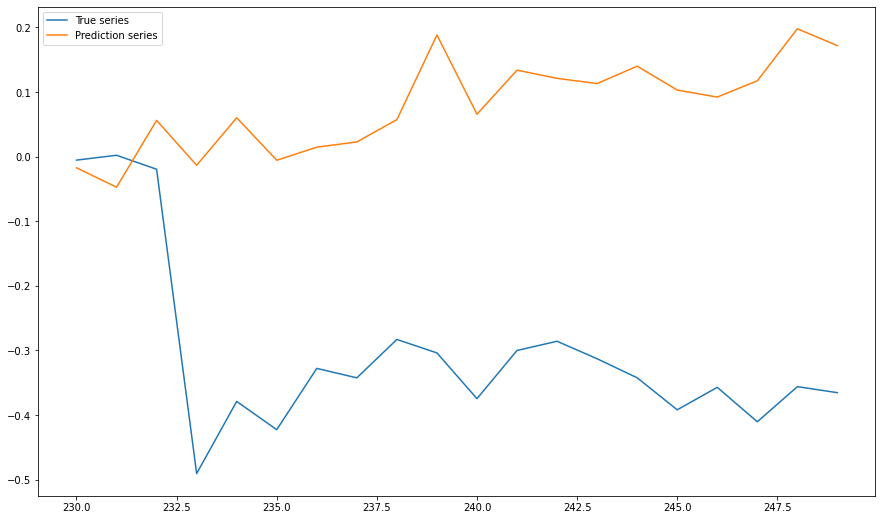

MAE is 0.3879053592681885
(20,) (20,)


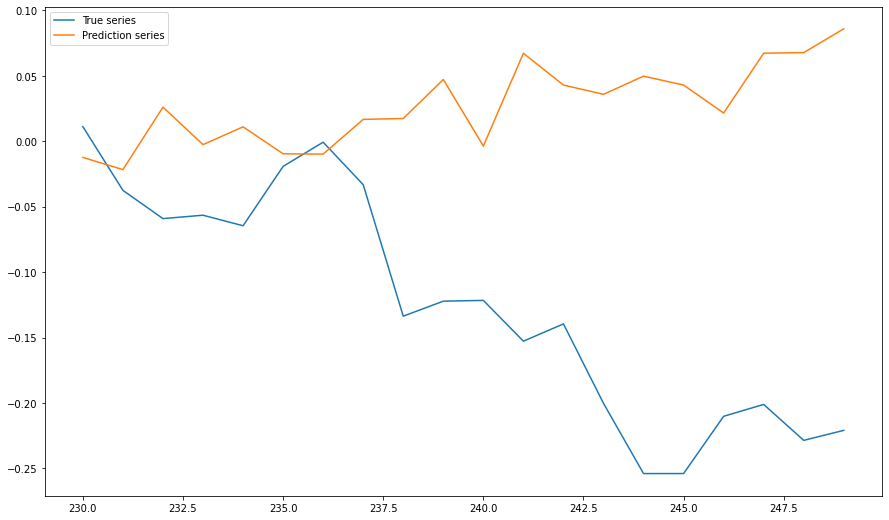

MAE is 0.15522401034832
(20,) (20,)


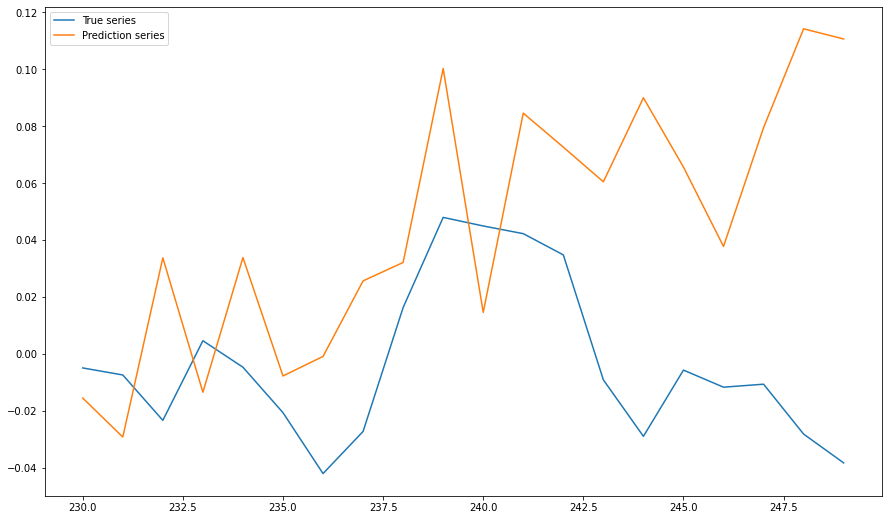

MAE is 0.05611645057797432
(20,) (20,)


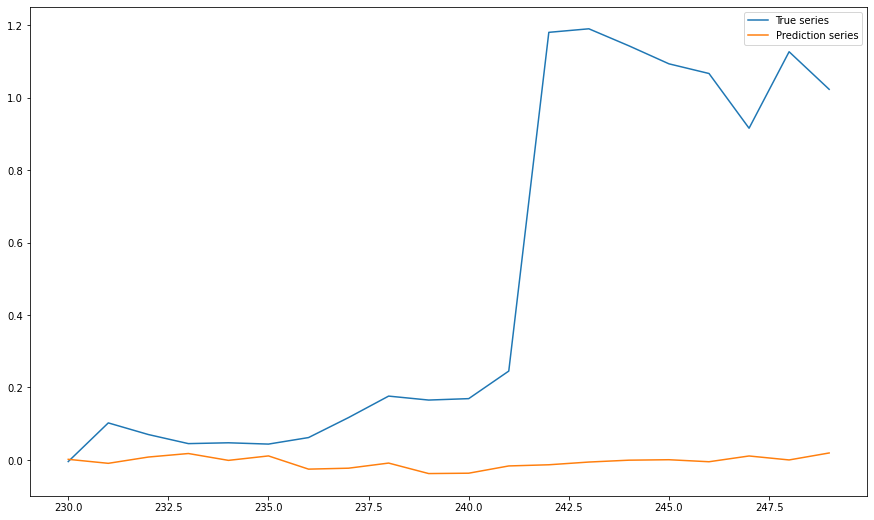

MAE is 0.5053451657295227
(20,) (20,)


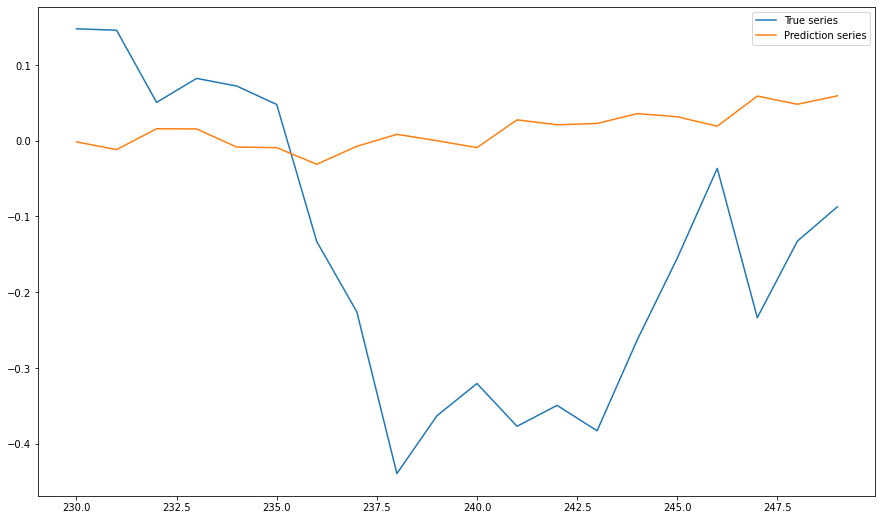

MAE is 0.21652822196483612
(20,) (20,)


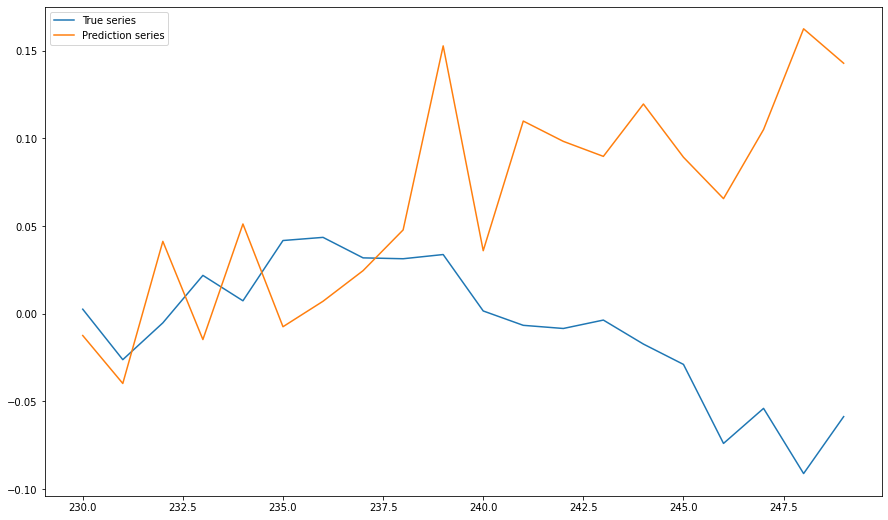

MAE is 0.08720085024833679
(20,) (20,)


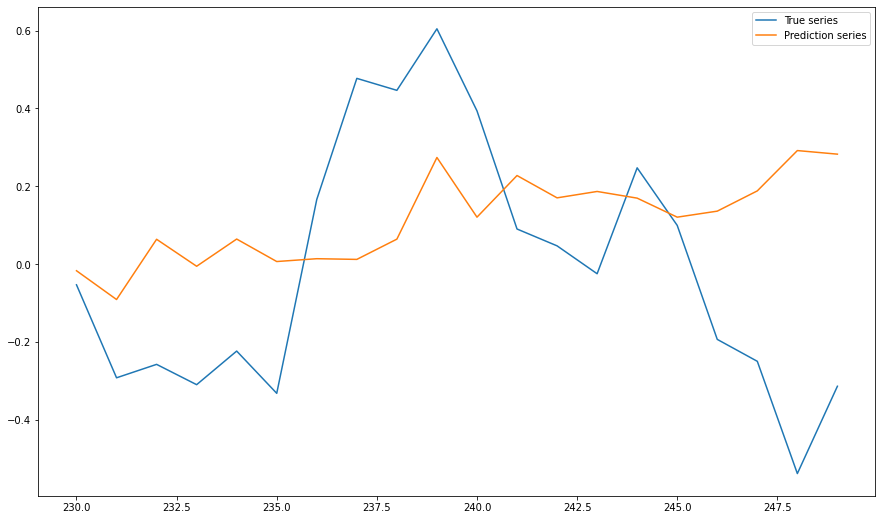

MAE is 0.29297494888305664
(20,) (20,)


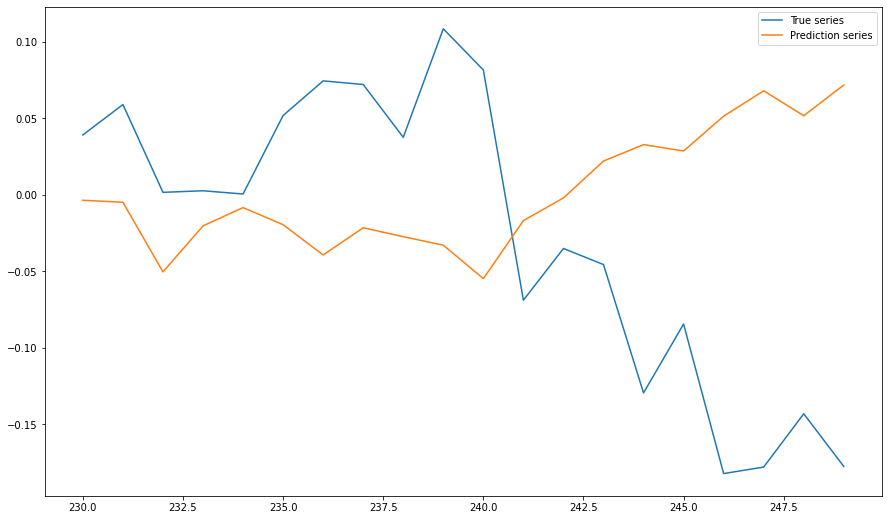

MAE is 0.10816469043493271
(20,) (20,)


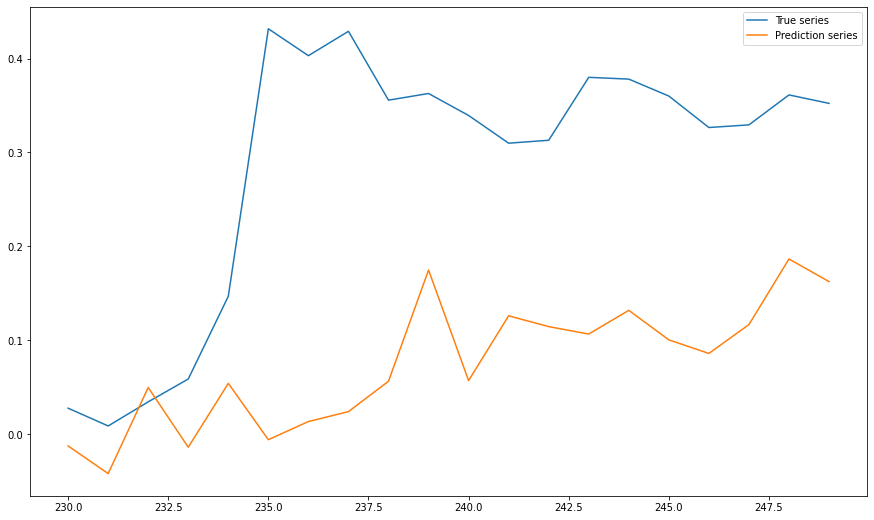

MAE is 0.21282470226287842
(20,) (20,)


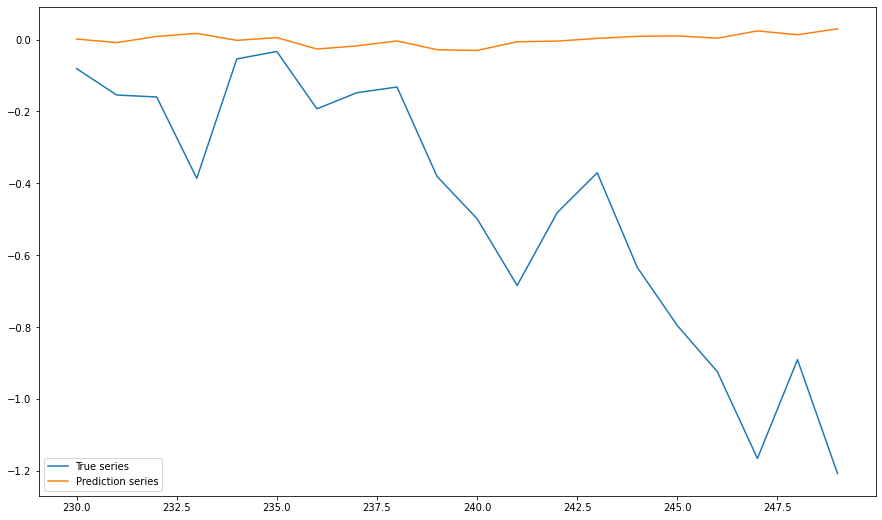

MAE is 0.46904683113098145
(20,) (20,)


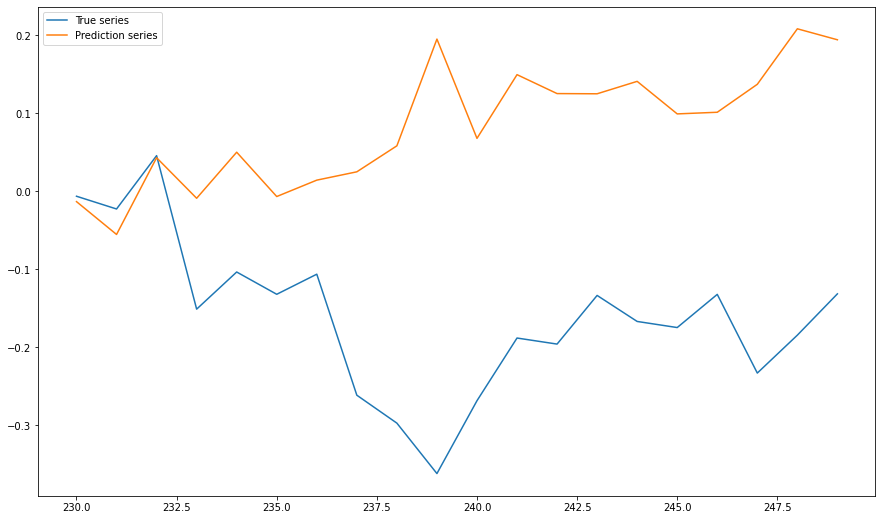

MAE is 0.24695000052452087
(20,) (20,)


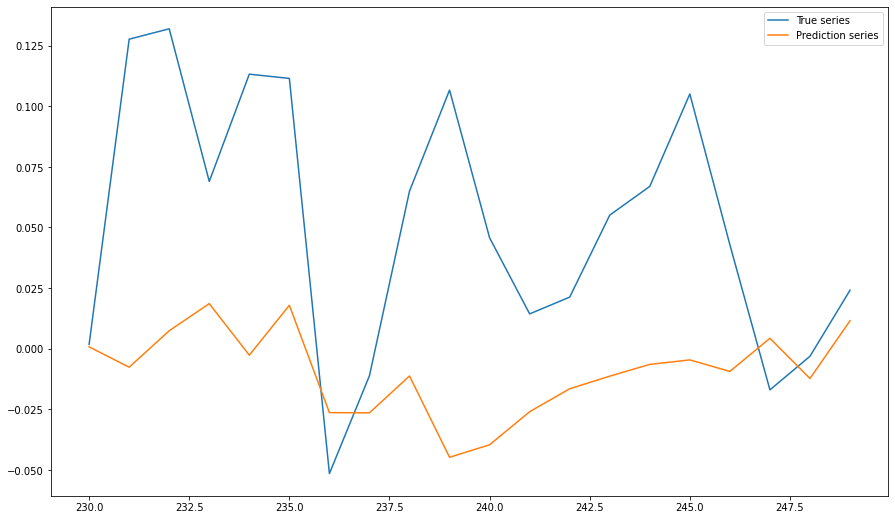

MAE is 0.06487422436475754
(20,) (20,)


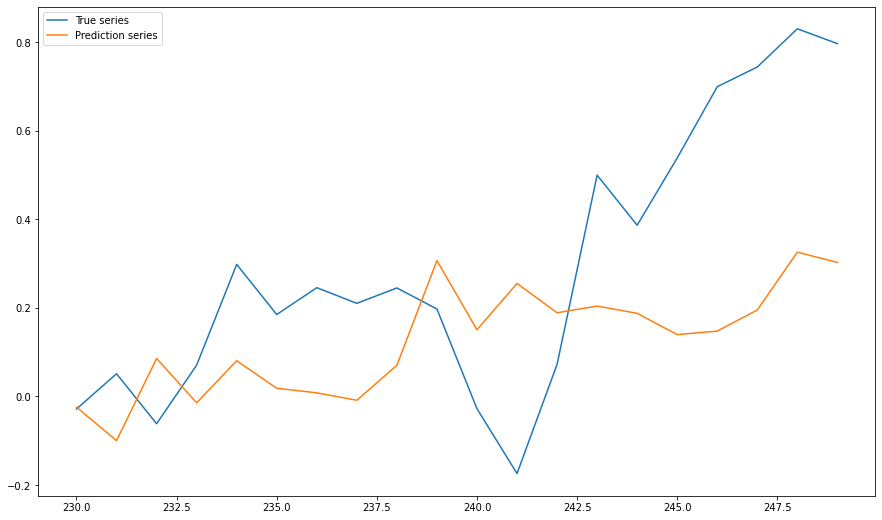

MAE is 0.2615603506565094
(20,) (20,)


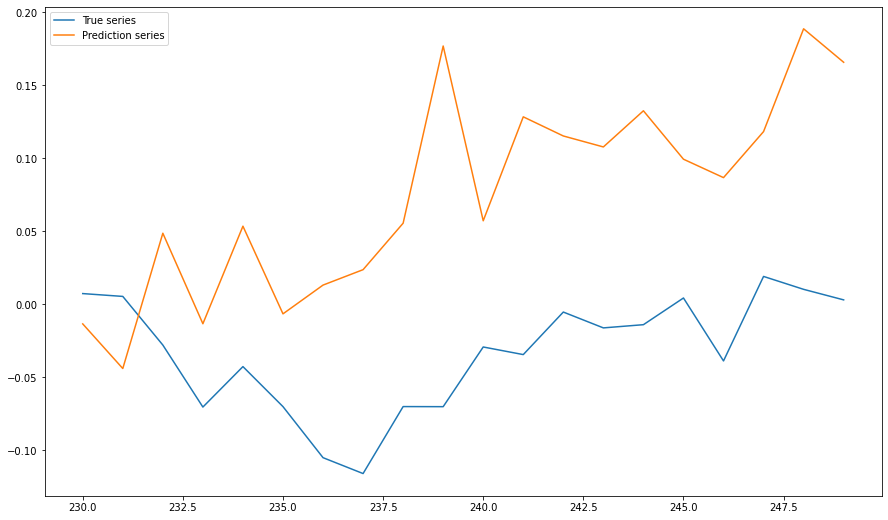

MAE is 0.11485759913921356
(20,) (20,)


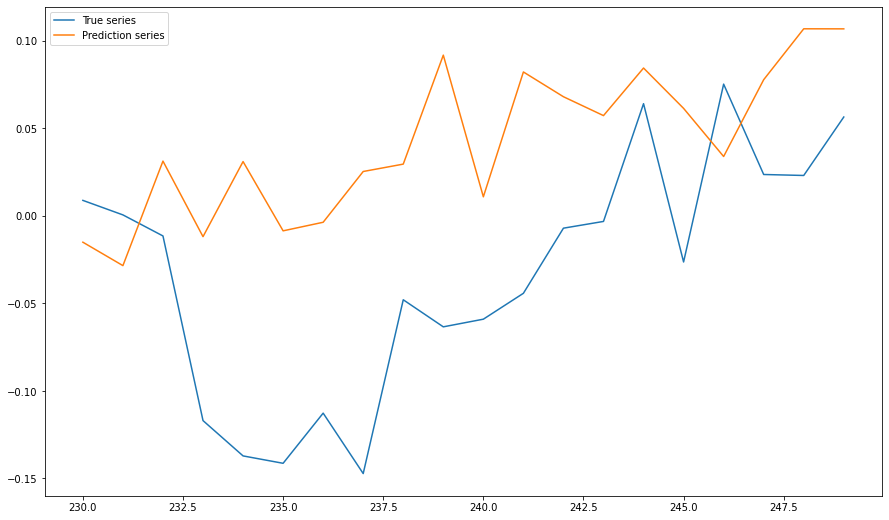

MAE is 0.08426593989133835
(20,) (20,)


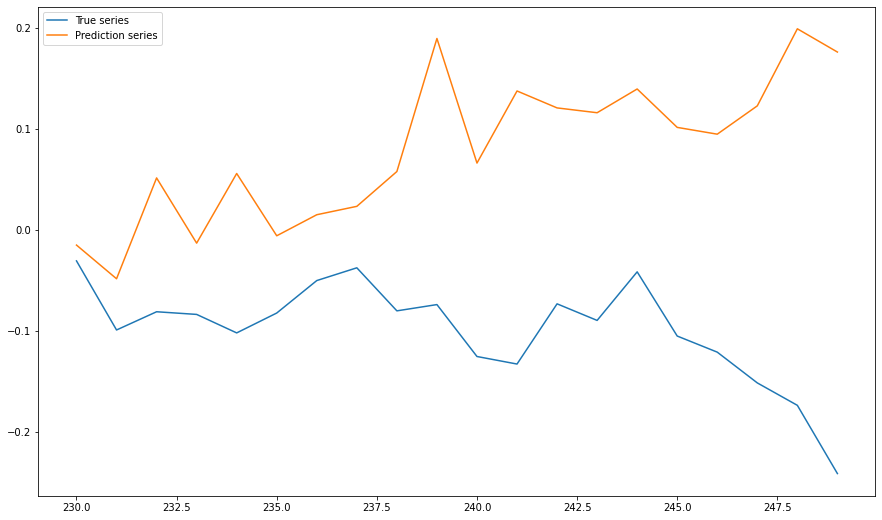

MAE is 0.17796412110328674
(20,) (20,)


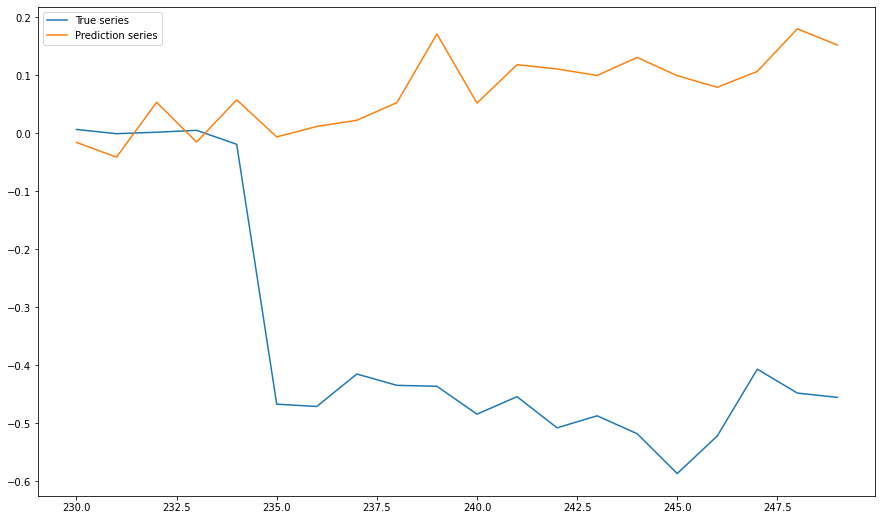

MAE is 0.4346870481967926
(20,) (20,)


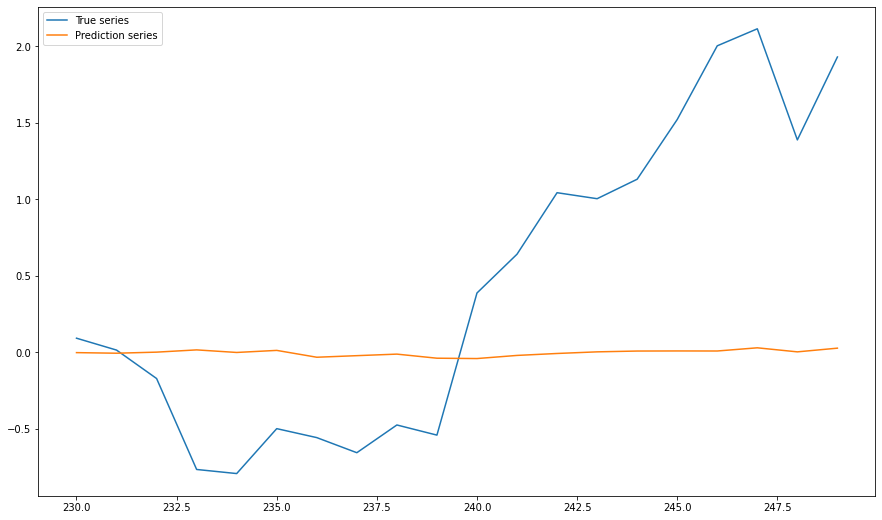

MAE is 0.8815754652023315
(20,) (20,)


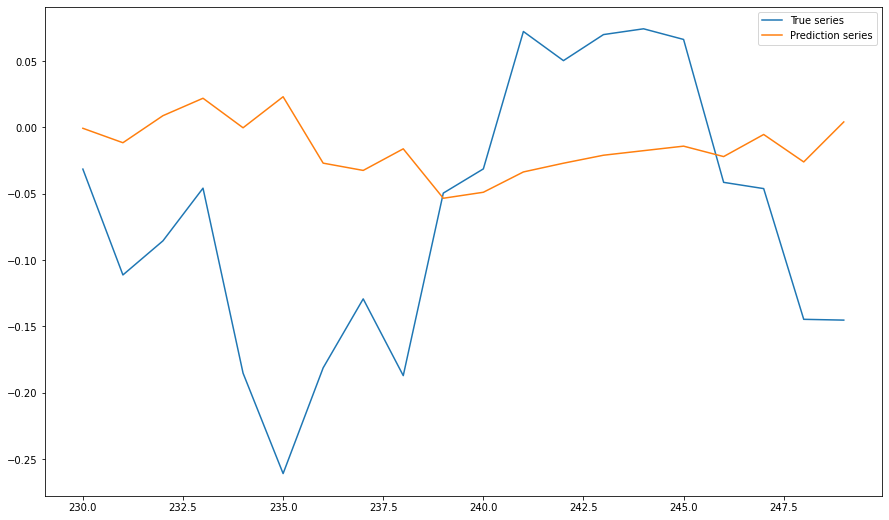

MAE is 0.09890318661928177
(20,) (20,)


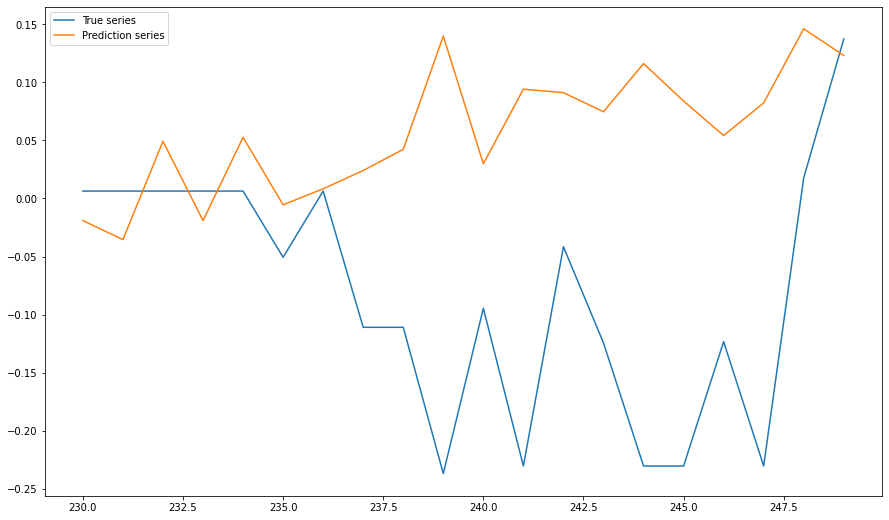

MAE is 0.14846643805503845
(20,) (20,)


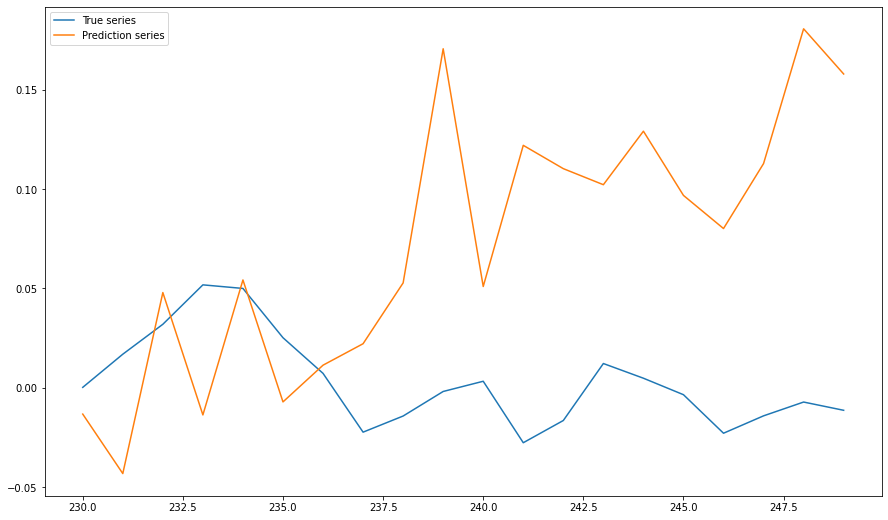

MAE is 0.08528240770101547
(20,) (20,)


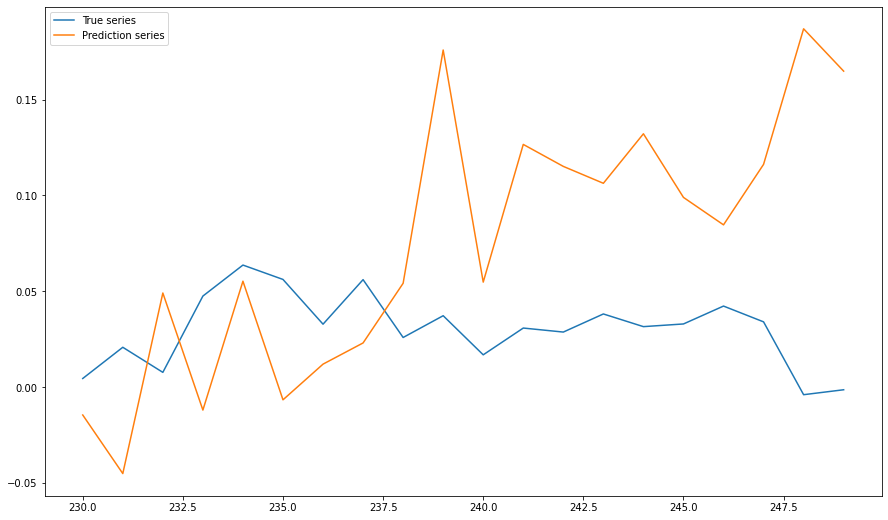

MAE is 0.07074760645627975
(20,) (20,)


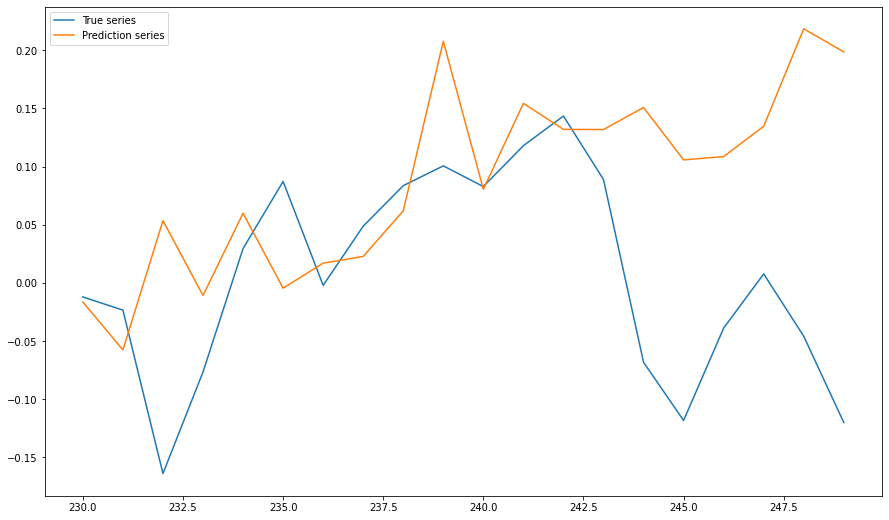

MAE is 0.10060181468725204
(20,) (20,)


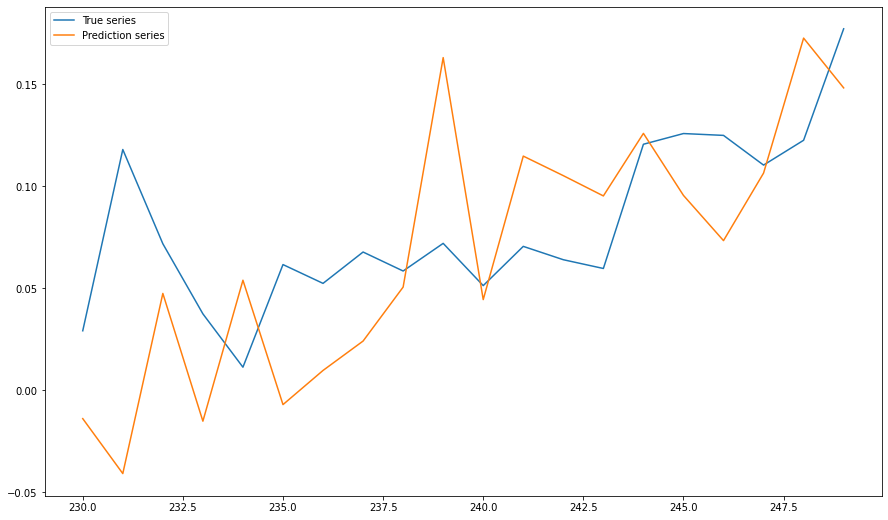

MAE is 0.04365892335772514
(20,) (20,)


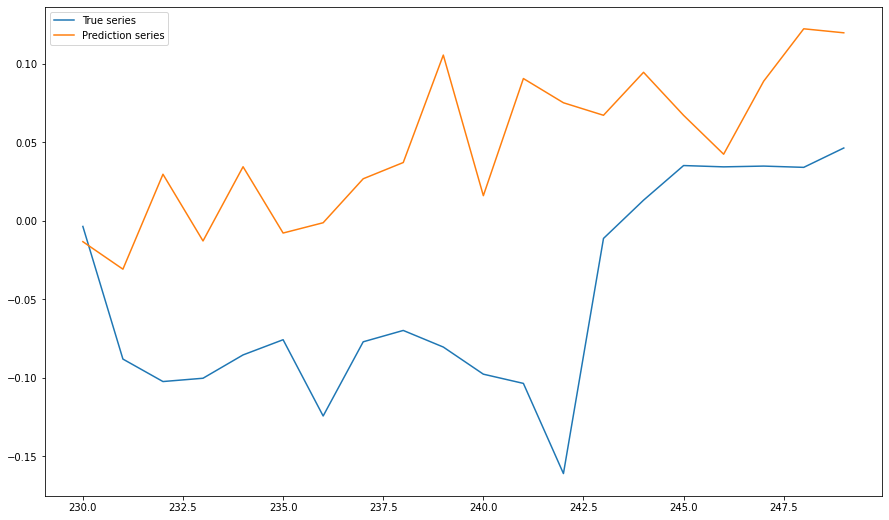

MAE is 0.09771199524402618


In [238]:
testloader = DataLoader(partition['test'], batch_size = 1, shuffle = False)
model.eval()

# evaluate
with torch.no_grad():
    for i, (X, y) in enumerate(testloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 0].float().to(args.device)
 
        # en-decoder outputs tensor 
        y_pred = model(X)
        
        # y values to cpu
        y_true = y_true.cpu().detach().numpy().reshape(-1)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1)

        print(y_true.shape, y_pred.shape)

        plt.plot(np.arange(0, 120), y_true, '*-',label = 'True series')
        plt.plot(np.arange(0, 120), y_pred, '.-',label = 'Prediction series')
        plt.legend()
        plt.show()

        
        # get the batch loss
        MAE = mean_absolute_error(y_true, y_pred)
        print(f'MAE is {MAE}')
        

torch.Size([1, 250, 9])
(20,) (20,)


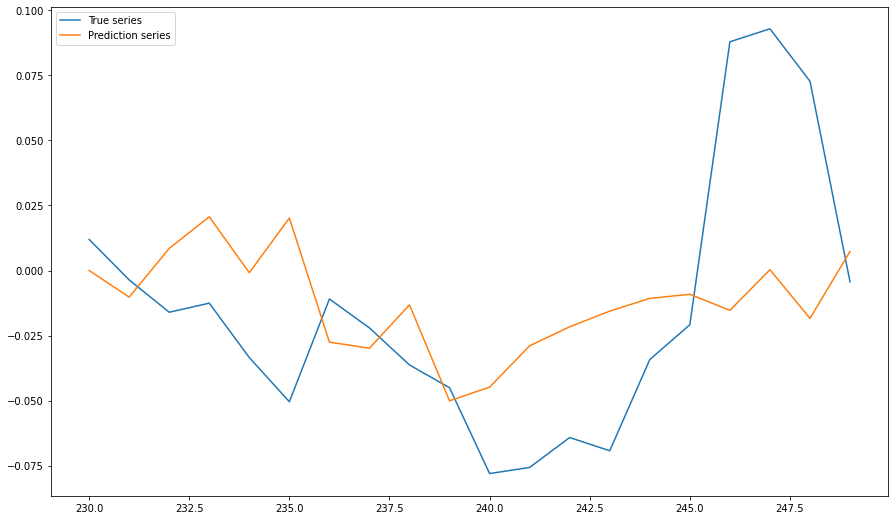

MAE is 0.03712604567408562


In [224]:
testloader2 = DataLoader(partition['train'], batch_size = 1, shuffle = True, drop_last = True)
model.eval()
# evaluate

with torch.no_grad():
    for i, data in enumerate(testloader2):
        print(data.shape)

        X = data[:, :args.x_frames, :].transpose(0, 1).float().to(args.device)
        y_true = data[:, args.x_frames:, 0].float().to(args.device)
        model.hidden = model.init_hidden(X.shape[1])

        # en-decoder outputs tensor 
        y_pred = model(X)
        
        # y values to cpu
        y_true = y_true.cpu().detach().numpy().reshape(-1)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1)

        print(y_true.shape, y_pred.shape)

        plt.plot(np.arange(args.x_frames, args.x_frames+args.y_frames), y_true, label = 'True series')
        plt.plot(np.arange(args.x_frames, args.x_frames+args.y_frames), y_pred, '-', label = 'Prediction series')
        plt.legend()
        plt.show()

        # get the batch loss
        MAE = mean_absolute_error(y_true, y_pred)
        print(f'MAE is {MAE}')
        break
